# <font color="#8333ff"><center>Détectez des faux billets avec R ou Python</center></font>


## Mise en situation

## Sommaire

**Partie1: Importation, inspection et nettoyage des données**
- <a href="#C1">1.Importation et inspection</a>
- <a href="#C2">2.Traitement des valeurs manquantes</a>
    - <a href="#C3">2.1.Suppression des lignes avec des valeurs NaN </a>
    - <a href="#C4">2.2.Imputation par la moyenne</a>
    - <a href="#C5">2.3.La régression linéaire multiple</a>
        - <a href="#C6">2.3.1.Régression sur les données brutes</a>
        - <a href="#C7">2.3.2.Régression sur les données standardisées</a>
        - <a href="#C8">2.3.3 Vérification des hypothèses</a>
        - <a href="#C9">2.3.4 Identification des individus atypiques et influents</a>
- <a href="#C10">3.Outliers</a>

**Partie 2: Analyse descriptive des données**
- <a href="#C11">1.Analyse univariée</a>
- <a href="#C12">2.Analyse multivariée</a>
- <a href="#C13">3.Analyse en composantes principales</a>

**Partie3: Identification des contrefaçons des billets**
- <a href="#C14">1. 1.Identification des contrefaçons par la méthode K-means</a>
- <a href="#C15">2. Classification par l’algorithme K Nearest Neighbors Knn</a>
- <a href="#C16">3. Classification par régression logistique</a>
    - <a href="#C17">3.1 Visualisation</a>
    - <a href="#C18">3.2 Régression logistique après  la suppression des lignes avec des valeurs NaN</a>
    - <a href="#C19">3.3 Régression logistique cas ou les valeurs manquantes sont imputées par la moyenne</a>
    - <a href="#C20">3.4 Régression logistique cas ou valeurs manquantes imputées grace à une régresssion linéaire</a>
        - <a href="#C21">3.4.1 Régression logistique avec statsmodels et analyse des résultats statistiques</a>
        - <a href="#C22">3.4.2 Logistic Regression Assumptions</a>
        - <a href="#C23">3.4.3 Logistic regression (Scikit-learn package)</a>
- <a href="#C24">4. Les indicateurs pour valider un modèle</a>
- <a href="#C25">5.Prédiction sur des données inconnues</a>


In [9]:
# Import de librairies.
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import math as mt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection  import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import neighbors
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

from scipy.stats import chi2
from scipy.stats import t, shapiro
import scipy.stats as stats
import researchpy as rp
import warnings
warnings.filterwarnings('ignore')
import webbrowser

## **Partie1: Importation, inspection et nettoyage des données**
## <a name="C1">1.Importation et inspection</a>

In [10]:
# Chargement de données
Billets = pd.read_csv('billets.csv', sep=';')

In [11]:
# Affichage
Billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [12]:
# Dimensions
Billets.shape

(1500, 7)

In [13]:
# La somme des valeurs manquantes 
Billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [14]:
# lignes dupliquées  
Billets.loc[Billets[['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']].duplicated(keep=False),:].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [15]:
# Des indications globales
Billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [16]:
# Des statistiques descriptives
Billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Nous avons six dimensions en plus de la colonne 'is_genuine' permettant de distinguer les vrais et les faux billets. Les types des données sont ceux attendus. Il manque des données seulement pour margin_low.

## <a name="C2">2.Traitement des valeurs manquantes </a>
## <a name="C3"><font color="#8333ff">2.1.Suppression des lignes avec des valeurs NaN </font> </a>

In [17]:
BillesSansLignesNan = Billets.copy(deep= True)
BillesSansLignesNan = BillesSansLignesNan.dropna()
BillesSansLignesNan.shape

(1463, 7)

## <a name="C4"><font color="#8333ff">2.2.Imputation par la moyenne</font> </a>

In [18]:
BilletsMoyenne = Billets.copy(deep = True)
BilletsMoyenne.loc[BilletsMoyenne['margin_low'].isnull(), 'margin_low' ] = np.mean(BilletsMoyenne['margin_low'])


In [19]:
# La somme des valeurs manquantes 
BilletsMoyenne.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

## <a name="C5"><font color="#8333ff">2.3.La régression linéaire multiple </font> </a>
On veut appliquer la régression linéaire pour Modéliser la dimension margin_low en fonction de toutes les autres variables.
La régression linéaire suppose une relation linéaire entre les variables indépendantes et la variable dépendante.

In [20]:
# Matrice de corrélation
Billets.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


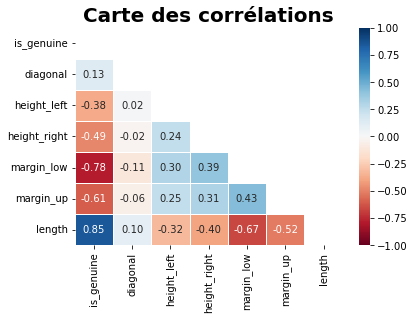

In [21]:
# Heatmap
mask = np.triu(np.ones_like(Billets.corr(), dtype=bool))
sns.heatmap(Billets.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Carte des corrélations', fontsize = 20 , fontweight='bold')
plt.show()

In [22]:
Billets.corr()['margin_low']

is_genuine     -0.783032
diagonal       -0.111534
height_left     0.302643
height_right    0.391085
margin_low      1.000000
margin_up       0.431606
length         -0.666753
Name: margin_low, dtype: float64

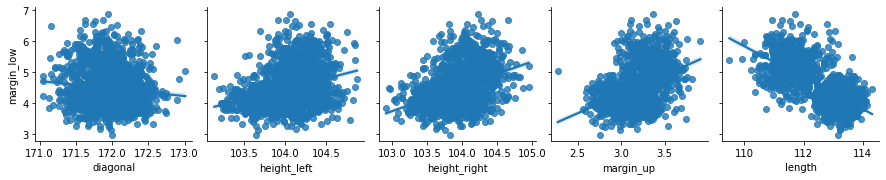

In [23]:
# Visualisation 
sns.pairplot(Billets, x_vars =['diagonal','height_left','height_right','margin_up','length'], y_vars ='margin_low', kind = 'reg')

### <a name="C6">2.3.1.Régression sur les données brutes</a>


In [24]:
# Régression linéaire à l’aide de Scikit-learn. 
# Separation des données
Billets_regL = Billets.dropna()
Billets_regL_test = Billets.loc[Billets.isnull().any(axis=1)]

# Splitting: Creation de X_train, X_test et y_train :
X_train = Billets_regL[['diagonal','height_left','height_right','margin_up','length']]
y_train = y = Billets_regL['margin_low']
X_test = Billets_regL_test[['diagonal','height_left','height_right','margin_up','length']]
# On instancie 
Linreg= LinearRegression()
# Fit model to training data
Linreg.fit(X_train,y_train)
print(Linreg.intercept_)
print(Linreg.coef_)

# Making predictions
y_pred = Linreg.predict(X_test)


22.994842714447906
[-0.11105978  0.18412242  0.25713805  0.2561879  -0.40910293]


In [25]:
# Régression avec statsmodels sur données brutes
Billets_regL = Billets.dropna()
# Régresser margin_low en fonction des autres variables 
reg_multi = smf.ols('margin_low~diagonal + height_left + height_right + margin_up + length', data = Billets_regL).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 22 Jan 2023   Prob (F-statistic):          2.60e-202
Time:                        17:28:20   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Non-colinéarité :
L'hypothèse de non-colinéarité suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres.<br>
Si les colonnes de X sont colinéaires, alors la matrice n'est pas de rang plein, ce qui conduit à une solution des MCO non unique.<br>

Rappels:<br>
S'il y a colinéarité parfaite, le determinant de la matrice XTX est nul, la matrice a autant de valeurs propres nulles que de relations de colinéarité parfaite.<br>
S'il y a quasi-colinéarité (colinéarité) le déterminant de la matrice XTX est proche de 0, la matrice a autant de valeurs propres très petites que de relations de colinéarité.<br>
Le facteur d'influence de la variance, noté VIF, de la variable Xj , j∈{1,…,p} , est défini par : VIFj=1/(1−R²j).<br>
En pratique, une valeur VIFj>10 indique un problème de colinéarité éventuel.

In [26]:
# Matrice de corrélation, valeurs propres
corr = np.corrcoef(Billets_regL[['diagonal','height_left','height_right','margin_up','length']], rowvar=0)
w, v = np.linalg.eig(corr)
w

array([2.04129661, 1.0139501 , 0.45603168, 0.78367538, 0.70504623])

In [27]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = Billets_regL[["diagonal","height_left","height_right", "margin_up", "length"]].columns
# calculating VIF for each feature
variables = reg_multi.model.exog
vif_data["VIF"] = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
print(vif_data)

        feature       VIF
0      diagonal  1.013613
1   height_left  1.138261
2  height_right  1.230115
3     margin_up  1.404404
4        length  1.576950


<div class="alert alert-block alert-info">
$Test$ $global$<br>
Prob(F-Statistic): L'hypothèse nulle du test de Fisher est que tous les coefficients sont nuls( H0:β2=…=βp=0 , H1:∃j∈{2,…,p}/βj≠0) . Ici, elle est inférieure au seuil alpha 5 % , on rejette l'hypothèse nulle, le modèle est donc significatif globalement.<br>
    
    
$Test $ $de $ $significativité $ $sur$ $ chacune$ $ des $ $variables$ $ explicatives:$<br>
P>|t| : L'hypothèse nulle du test de Student est que le coefficients de la variable explicative j est nul (H0:βj=0 ;H1:βj≠0  pour j∈{1,…,p}).les p_values sont tous inférieurs au seuil alpha 5 %, on rejette l'hypothèse nulle pour toutes les variables.
On conserve la variable Xj pour j j∈{2,…,p} comme explicative (tous les paramètres sont significatifs).<br>
    
    
$ Coefficient$ $ de$ $ détermination$<br>   
R²mesure la part de la variation totale de Y(margin_low) expliquée par le modèle de régression sur X.Il vaut environ 0.477, tout comme le R² ajusté.Le modèle de régression explique 47,7 % de la variation
totale.
 
    
$Intercept$<br>
La valeur d'interception est la valeur moyenne estimée de notre variable dépendante lorsque toutes nos valeurs de variables indépendantes sont égales à 0. L'intercepte est très grand d'ou ce message "The condition number is large, 1.94e+05. This might indicate that there are strong multicollinearity or other numerical problems" car le calcul de vif ainsi que le déterminant montrent qu'on n'a pas un problème de colinéarité.      
<br>
</div>  

### <a name="C7">2.3.2.Régression sur les données standardisées</a>

In [28]:
# Data
Billets_standard = Billets[['diagonal','height_left','height_right',
                                         'margin_low','margin_up','length']]
# Standardisation
features = Billets_standard.columns # Enregister les colonnes dans une variable nommée features
# On instancie
scaler = StandardScaler()
# On fit
scaler.fit(Billets_standard)
# On transforme
Billets_standard = scaler.transform(Billets_standard)
Billets_standard = pd.DataFrame(Billets_standard)
Billets_standard.columns = features
df_standard = Billets_standard.dropna()
df_manquante = Billets_standard.loc[Billets_standard['margin_low'].isnull()]
# Régresser margin_low en fonction des autres variables 
reg_multi = smf.ols('margin_low~diagonal + height_left + height_right + margin_up + length', data = df_standard).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 22 Jan 2023   Prob (F-statistic):          2.60e-202
Time:                        17:28:26   Log-Likelihood:                -1601.3
No. Observations:                1463   AIC:                             3215.
Df Residuals:                    1457   BIC:                             3246.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0038      0.019     -0.198   

### <a name="C8">2.3.3 Vérification des hypothèses </a>
Nous allons ici réaliser les tests à un niveau  𝛼 = 5 % :
### Normalité de la distribution des résidus
L'hypothèse gaussienne consiste à considérer que ϵ suit une loi normale N(0,σ2)<br>
La loi normale nous permettra notamment de tester la significativité des paramètres.<br>
Pour tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.<br>

In [29]:
# Normalite:
# Hypothèse nulle H0: l’échantillon est issu d’une population normalement distribuée.
# Hypothèse H1: l’échantillon n'est pas issu d’une population normalement distribuée.
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

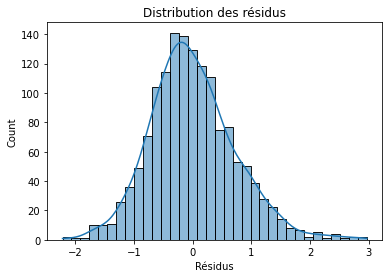

In [30]:
# Graphique:
sns.histplot(reg_multi.resid, kde=True)
plt.xlabel("Résidus")
plt.title("Distribution des résidus")
plt.show()

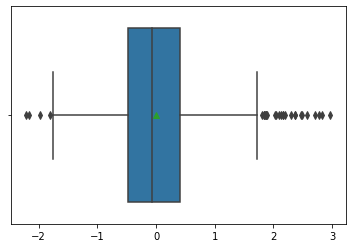

In [31]:
# Boxplot
sns.boxplot(x = reg_multi.resid, showmeans=True);

L'allure de l'histogramme est assez classique : centrée et à peu près symétrique.
Le boxplot montre une distribution raisonnable avec la moyenne proche de la médiane (indiquant la symétrie).

<div class="alert alert-block alert-info">
Une p-value inférieure à alpha pour le test de Shapiro-Wilk indique que l'hypothèse nulle de normalité de la distribution des résidus est rejetée.<br>
Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.
</div>  


### Homoscédasticité : 
Var(εi)=σ2  (leur variance est constante et égale à σ2 ) <br>
Les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire.<br>
(H0): Homoscédasticité: (les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante.<br>
(Ha): hétéroscédasticité<br> 
        

In [32]:
# Perform a Breusch-Pagan test.
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216180973e-16


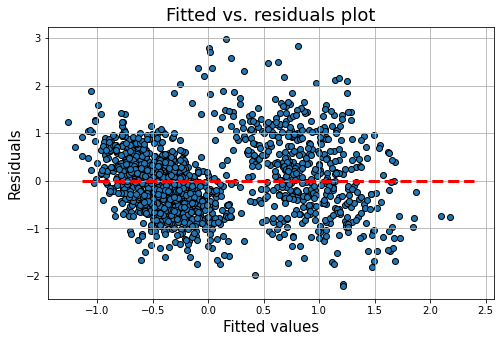

In [33]:
# Fitted vs. residuals
plt.figure(figsize=(8,5))
p=plt.scatter(x=reg_multi.fittedvalues,y=reg_multi.resid,edgecolor='k')
xmin=min(reg_multi.fittedvalues)
xmax = max(reg_multi.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Homoscédasticité')

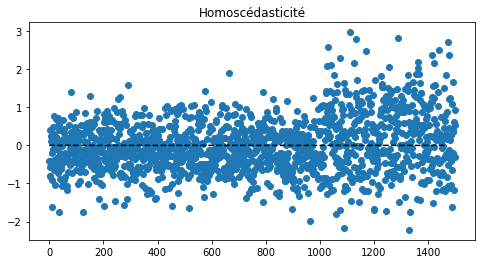

In [34]:
# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(df_standard.index, y=reg_multi.resid)
plt.plot(np.repeat(0, len(df_standard.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

The fitted vs. residuals plot shows violation of the constant variance assumption - Heteroscedasticity.


 </div> <div class="alert alert-block alert-warning">La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).
La visualisation graphique des résidus studentisés montre un nuage avec une forme conique peut laisser présager un effet hétéroscédastique..<b>

### Évaluation de l’hypothèse de l’indépendance des résidus (auto-corrélation)

Cov(εi,εj)=0 si i≠j (elles n'ont pas de dépendance linéaire)<br>
Le test de Durbin-Watson est le plus souvent utilisé.<br> 
H0 : l'indépendance <br>
H1 :les résidus sont non-indépendants.<br>

In [35]:
# Le test de Durbin-Watson
from statsmodels.stats.stattools import durbin_watson
# Durbin-Watson test
print(durbin_watson(reg_multi.resid))

1.8927631665241555


S'il n'y a pas d'autocorrélation, la valeur doit être centrée autour de 2.
Plus on se rapproche de 0, plus les autocorrélations sont négatives.
Plus on se rapproche de 4, plus les autocorrélations sont positives.
On peut admettre de rejeter les autocorrélations si la valeur rendue est entre 1.5 et 2.5.

<div class="alert alert-block alert-info">
Il n'y a donc pas d'autocorrélation. Les résidus sont indépendantes.
</div> 

### Non-colinéarité : 

In [36]:
# Matrice de corrélation, valeurs propres
corr = np.corrcoef(df_standard[['diagonal','height_left','height_right','margin_up','length']], rowvar=0)
w, v = np.linalg.eig(corr)
w

array([2.04129661, 1.0139501 , 0.45603168, 0.78367538, 0.70504623])

In [37]:
# Determinant
d = np.linalg.det(corr)
print(d)

0.5215206485383336


In [38]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_standard[["diagonal","height_left","height_right", "margin_up", "length"]].columns
# calculating VIF for each feature
variables = reg_multi.model.exog
vif_data["VIF"] = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
print(vif_data)

        feature       VIF
0      diagonal  1.013613
1   height_left  1.138261
2  height_right  1.230115
3     margin_up  1.404404
4        length  1.576950


Tous les VIF sont inférieurs à 10, il n'y a donc pas de problème de colinéarité parfaite.
Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible.

### <a name="C9">2.3.4 Identification des individus atypiques et influents </a>


Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.
Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [39]:
alpha = 0.05
n = df_standard.shape[0]
p = 6
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
#analyses['obs'].astype('float', inplace=True) 

#### Analysez l'atypicité des observations
##### Sur les variables explicatives :
Calculez les leviers:

La matrice de projection sur le sous-espace vectoriel engendré par les colonnes de X est communément notée H
Les termes diagonaux de H sont appelés "leviers des observations".
Leverage : Effet de levier : Dans les statistiques et en particulier dans l'analyse de régression, l'effet de levier est une mesure de la distance qui sépare les valeurs des variables indépendantes d'une observation de celles des autres observations.
On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [40]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n


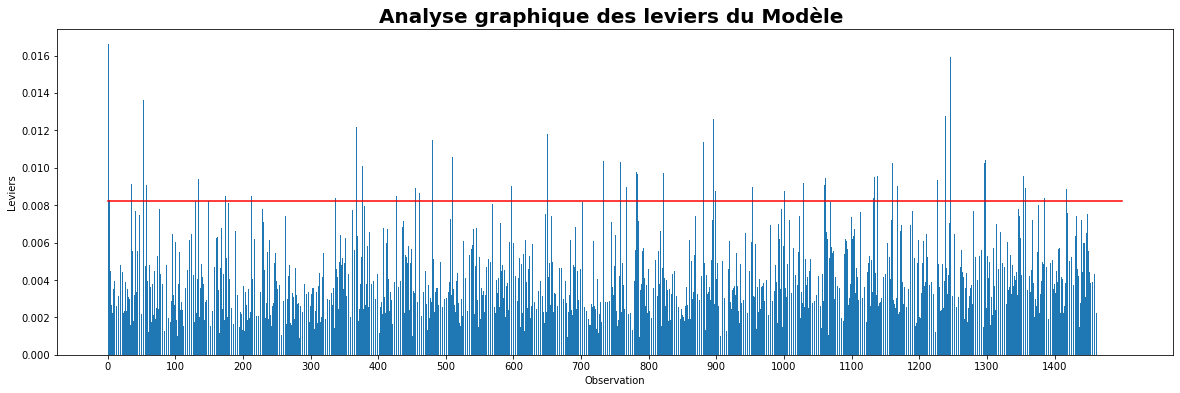

In [41]:
# Graphique:
plt.figure(figsize=(20,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.title('Analyse graphique des leviers du Modèle ', fontsize=20, fontweight='bold')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [42]:
analyses.loc[analyses['levier'] > seuil_levier, :].shape

(75, 2)

#### Sur la variable à expliquer :
##### Calculez les résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [43]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

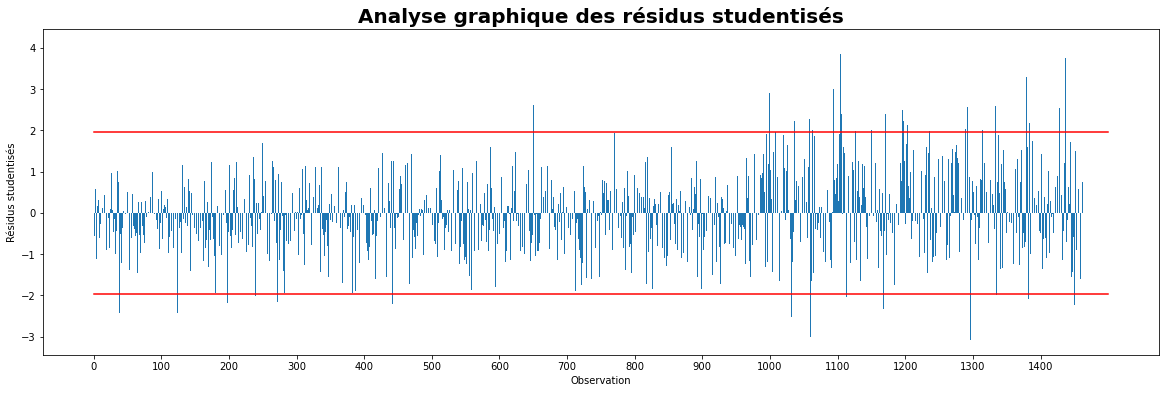

In [44]:
# Graphique:
plt.figure(figsize=(20,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.title('Analyse graphique des résidus studentisés', fontsize=20, fontweight='bold')
plt.show()

In [45]:
analyses[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent']  < -seuil_rstudent)]

,obs,levier,rstudent
10,11,0.002030,-2.221047
37,38,0.001798,-2.426466
123,124,0.006449,-2.414722
197,198,0.002204,-2.189564
238,239,0.006155,-2.018889
...,...,...,...
1427,1428,0.003757,2.548894
1436,1437,0.001505,3.741140
1441,1442,0.009325,3.280337
1449,1450,0.005530,-2.232347


#### Analysez l'influence des observations
#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [46]:
influence = reg_multi.get_influence().summary_frame()

In [47]:
analyses['dcooks'] = influence['cooks_d']
# Seuil (threshold), toutes valeurs au dessus aura une forte influence
seuil_dcook = 4/(n-p)  
print(round(seuil_dcook,5))

0.00275


On peut détecter les observations influentes comme ceci :

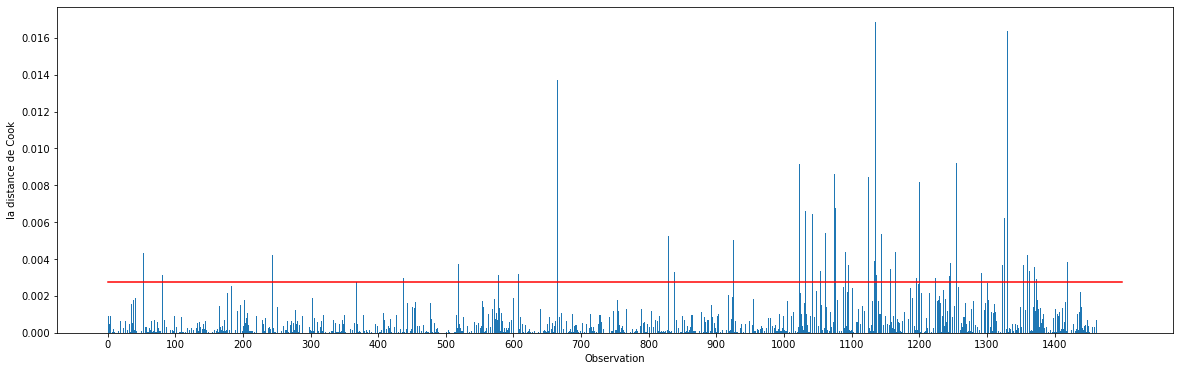

In [48]:
# Graphique:
plt.figure(figsize=(20,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('la distance de Cook')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [49]:
ObsInfluente = analyses.loc[ analyses['dcooks'] > seuil_dcook, :]
ObsInfluente.shape

(79, 4)

In [50]:
# Find number of observations which are BOTH outlier and highly influential
extreme = analyses[(analyses['dcooks'] > seuil_dcook) & 
                       (abs(analyses['rstudent']) >  seuil_rstudent)]
prop_extreme = round(100*(len(extreme) / n),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')


Proportion of highly influential outliers = 0.3%


In [51]:
# Display most influential outliers
extreme.sort_values("dcooks", ascending=False)

,obs,levier,rstudent,dcooks
1441,1442,0.009325,3.280337,0.009596
1031,1032,0.005115,-2.510481,0.006603
1321,1322,0.001112,2.582140,0.003448
1291,1292,0.005626,2.564383,0.003240
1195,1196,0.001681,2.504636,0.002971


In [52]:
# Predictions et imputation des valeurs manquantes
df_standard = Billets_standard.dropna()
df_manquante = Billets_standard.loc[Billets_standard['margin_low'].isnull()]
predict_nan = reg_multi.predict(df_manquante)
for i in predict_nan.index:
    Billets_standard.iloc[i, 3] = predict_nan[i]
# vérification    
Billets_standard.isna().sum()  

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [53]:
# data
billetsS= Billets_standard.copy(deep=True)
billetsS['is_genuine'] = Billets['is_genuine']

## <a name="C10">3.Outliers </a>

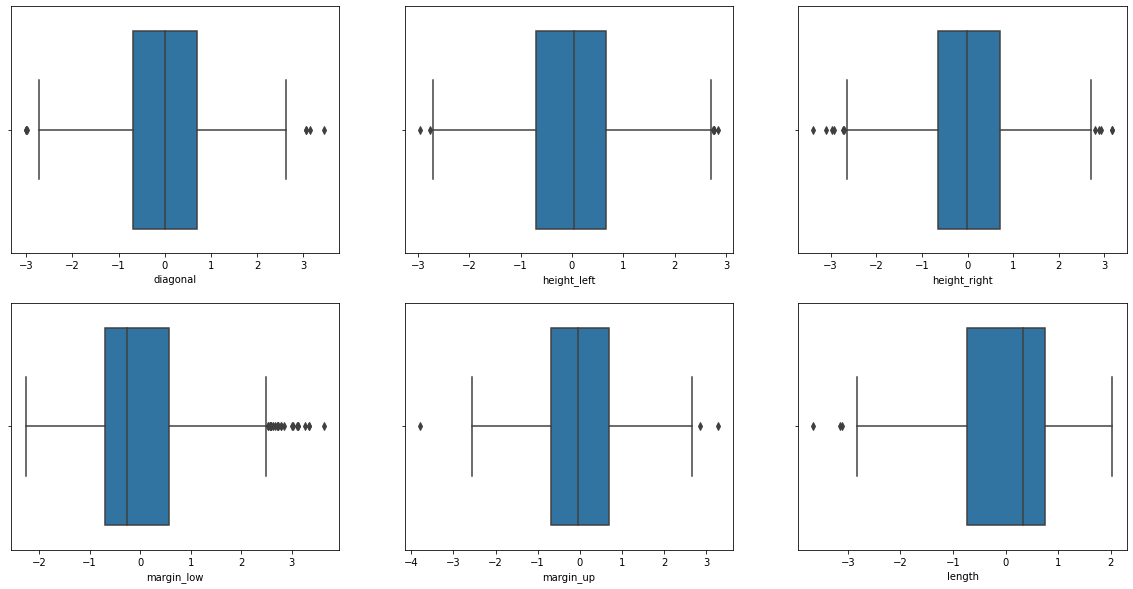

In [54]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,10))

for i in billetsS.loc[:, billetsS.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title
    plt.xlabel(i)
    sns.boxplot(x = billetsS[i])
    c = c + 1
plt.show()

In [55]:
# Detection numerique des outliers:
# Identification des outliers unidimentionnels
List_col = np.array(billetsS.columns)
List_col = np.delete(List_col,6)
allOutliers = []
for element in List_col:
    outliers = []
    q1 = np.quantile(billetsS[element], 0.25)
    q3 = np.quantile(billetsS[element], 0.75)
    iqr = q3-q1
    limite_sup = q3+(1.5*iqr)
    limite_inf = q1-(1.5*iqr)
    outliersByElement = billetsS.loc[(billetsS[element] <= limite_inf) | (billetsS[element] >= limite_sup)].index
    for outlierByElement in outliersByElement:
        outliers.append(outlierByElement)
        if outlierByElement not in allOutliers:
            allOutliers.append(outlierByElement)
    print("============================================================================================================")
    print("Les outliers pour l'élément ",element,'sont :')
    print(outliers)
print("============================================================================================================")
print("============================================================================================================")
print("============================================================================================================")
print("La liste de tous les outliers est", allOutliers)
print("============================================================================================================")
print("Le nombre de outliers unidimensionnels est", len(allOutliers))


Les outliers pour l'élément  diagonal sont :
[729, 828, 842, 1022, 1142, 1277, 1388]
Les outliers pour l'élément  height_left sont :
[0, 224, 292, 1090, 1150, 1382]
Les outliers pour l'élément  height_right sont :
[0, 77, 176, 193, 251, 522, 761, 1199, 1321, 1331, 1484]
Les outliers pour l'élément  margin_low sont :
[1023, 1027, 1031, 1041, 1053, 1075, 1092, 1110, 1124, 1133, 1134, 1169, 1254, 1290, 1322, 1345, 1348, 1353, 1420, 1426, 1441, 1459, 1464, 1473]
Les outliers pour l'élément  margin_up sont :
[664, 1029, 1270]
Les outliers pour l'élément  length sont :
[1082, 1355, 1453]
La liste de tous les outliers est [729, 828, 842, 1022, 1142, 1277, 1388, 0, 224, 292, 1090, 1150, 1382, 77, 176, 193, 251, 522, 761, 1199, 1321, 1331, 1484, 1023, 1027, 1031, 1041, 1053, 1075, 1092, 1110, 1124, 1133, 1134, 1169, 1254, 1290, 1322, 1345, 1348, 1353, 1420, 1426, 1441, 1459, 1464, 1473, 664, 1029, 1270, 1082, 1355, 1453]
Le nombre de outliers unidimensionnels est 53


## **Partie 2: Analyse descriptive des données**
## <a name="C11">1.Analyse univariée </a>

### Variables qualitatives

In [56]:
# Nombre de vrais et faux billets
billetsS['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Text(0.5, 1.0, 'Répartition des billets')

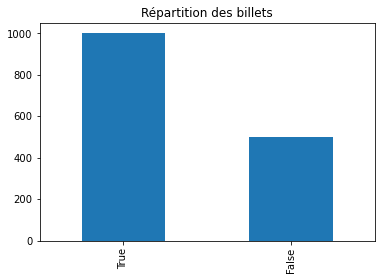

In [57]:
# Diagramme en bar
billetsS['is_genuine'].value_counts().plot(kind='bar')
plt.title("Répartition des billets")

In [58]:
rp.summary_cat(billetsS[['is_genuine']])

,Variable,Outcome,Count,Percent
0,is_genuine,True,1000,66.67
1,,False,500,33.33


### Variables quantitatives

In [59]:
# Les mesures de tendance centrale
Data= Billets.drop(columns= 'is_genuine')
colonnes = Data.columns.tolist()
for variable in colonnes:
    print('les mesures de tendences centrale de la variable', variable)
    print('la moyenne de la variable', variable, round(Billets[variable].mean(),2))
    print('la mediane de la variable', variable, round(Billets[variable].median(),2))
    print('les modes de la variable', variable, round(Billets[variable].mode(),2))
    print('====================================================================')

les mesures de tendences centrale de la variable diagonal
la moyenne de la variable diagonal 171.96
la mediane de la variable diagonal 171.96
les modes de la variable diagonal 0    171.99
Name: diagonal, dtype: float64
les mesures de tendences centrale de la variable height_left
la moyenne de la variable height_left 104.03
la mediane de la variable height_left 104.04
les modes de la variable height_left 0    103.95
Name: height_left, dtype: float64
les mesures de tendences centrale de la variable height_right
la moyenne de la variable height_right 103.92
la mediane de la variable height_right 103.92
les modes de la variable height_right 0    103.76
Name: height_right, dtype: float64
les mesures de tendences centrale de la variable margin_low
la moyenne de la variable margin_low 4.49
la mediane de la variable margin_low 4.31
les modes de la variable margin_low 0    4.08
1    4.10
2    4.18
Name: margin_low, dtype: float64
les mesures de tendences centrale de la variable margin_up
la moy

In [60]:
# Les mesures de dispersion
colonnes = Billets.columns.tolist()
for variable in colonnes:
    print('La variace empirique de la variable', variable, 'est:', round(Billets[variable].var(),3))
    print("L'écart-type empirique de la variable", variable, 'est', round(Billets[variable].std(),3))
    print('====================================================================')

La variace empirique de la variable is_genuine est: 0.222
L'écart-type empirique de la variable is_genuine est 0.472
La variace empirique de la variable diagonal est: 0.093
L'écart-type empirique de la variable diagonal est 0.305
La variace empirique de la variable height_left est: 0.09
L'écart-type empirique de la variable height_left est 0.299
La variace empirique de la variable height_right est: 0.106
L'écart-type empirique de la variable height_right est 0.326
La variace empirique de la variable margin_low est: 0.441
L'écart-type empirique de la variable margin_low est 0.664
La variace empirique de la variable margin_up est: 0.054
L'écart-type empirique de la variable margin_up est 0.232
La variace empirique de la variable length est: 0.762
L'écart-type empirique de la variable length est 0.873


In [61]:
# Les mesures de forme
colonnes = Billets.columns.tolist()
for variable in colonnes:
    print('Le skewness de la variable', variable, 'est', round(Billets[variable].skew(),2))
    print('Le kurtosis de la variable', variable, 'est', round(Billets[variable].kurtosis(),2))
    print('====================================================================')

Le skewness de la variable is_genuine est -0.71
Le kurtosis de la variable is_genuine est -1.5
Le skewness de la variable diagonal est -0.03
Le kurtosis de la variable diagonal est -0.13
Le skewness de la variable height_left est -0.09
Le kurtosis de la variable height_left est -0.2
Le skewness de la variable height_right est -0.0
Le kurtosis de la variable height_right est -0.03
Le skewness de la variable margin_low est 0.86
Le kurtosis de la variable margin_low est 0.22
Le skewness de la variable margin_up est 0.15
Le kurtosis de la variable margin_up est -0.25
Le skewness de la variable length est -0.82
Le kurtosis de la variable length est -0.28


array([[<AxesSubplot:title={'center':'diagonal'}>,
        <AxesSubplot:title={'center':'height_left'}>,
        <AxesSubplot:title={'center':'height_right'}>],
       [<AxesSubplot:title={'center':'margin_low'}>,
        <AxesSubplot:title={'center':'margin_up'}>,
        <AxesSubplot:title={'center':'length'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

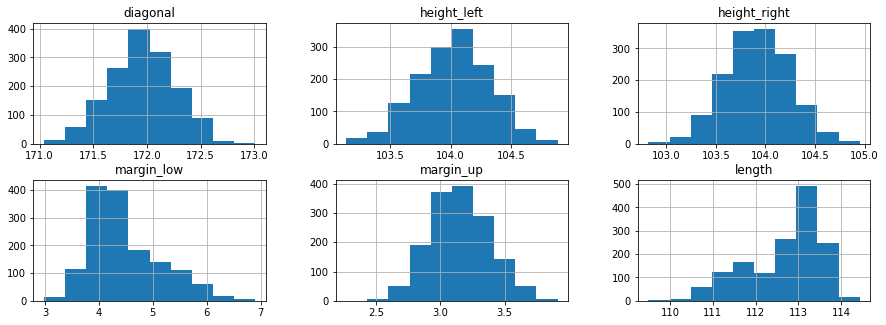

In [62]:
# La répartition des dimensions des billets
# Visualiser la distribution des fréquences
Billets.hist(layout= (3,3), figsize = (15,8))

## <a name="C12">2.Analyse multivariée </a>

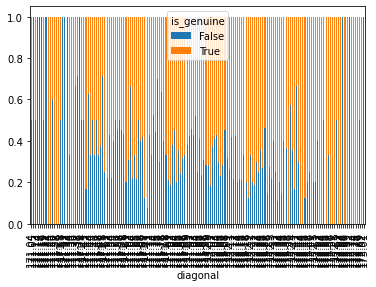

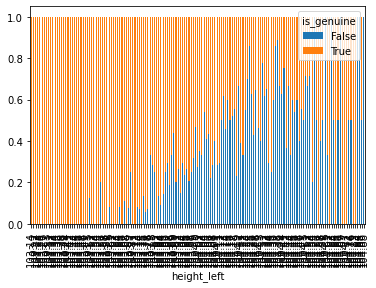

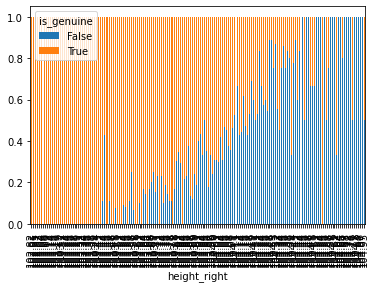

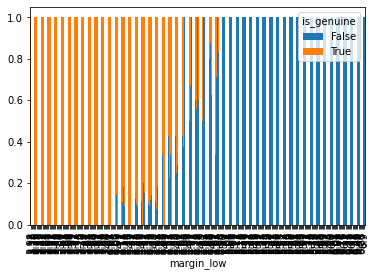

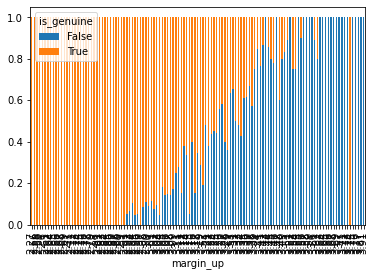

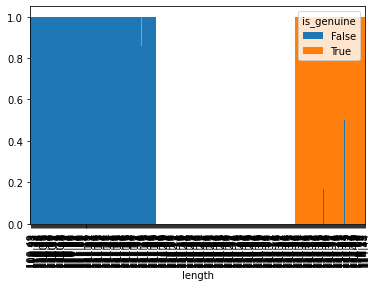

In [63]:
variable_list = ['diagonal','height_left','height_right','margin_low','margin_up','length']
for variable in variable_list:
    table = pd.crosstab(Billets[variable],Billets.is_genuine)
    table.div(table.sum(1).astype(float),axis =0).plot(kind = 'bar',stacked = True)



<div class="alert alert-block alert-info">
Ces graphiques montrent que la variable length permet de séparer complétement les billets en faux et vrais billets.<br>
La variable margin_low permet aussi la séparation des billets, il y a une petite zone de confusion ou pour la même valeur de margin_low on trouve des faux et vrais billets.<br>
La variable 'diagonal' ne permet pas l’identification des billets, pour une même valeur on trouve des faux et de vrais.<br>
</div>  

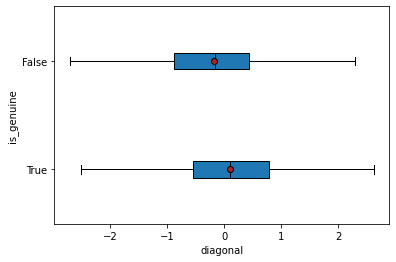

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


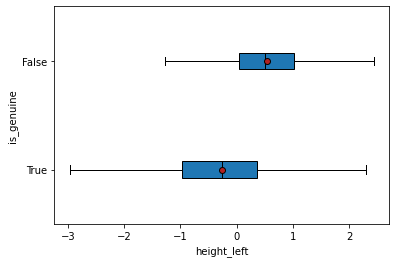

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


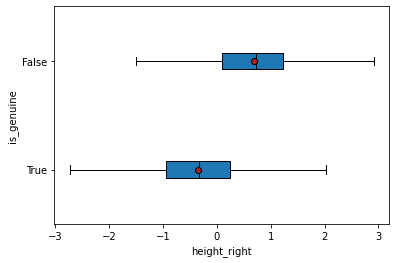

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


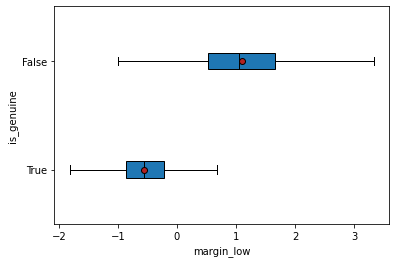

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


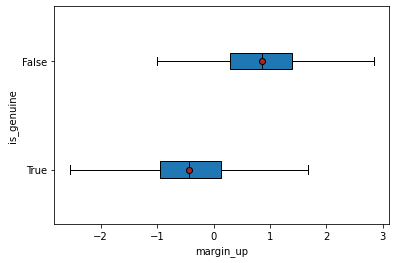

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


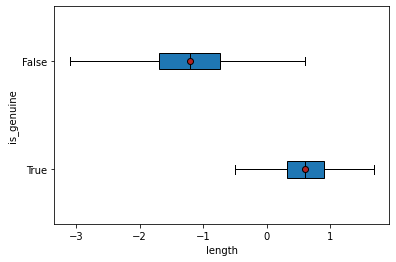

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [64]:

# Visualisation
variable_list = ['diagonal','height_left','height_right','margin_low','margin_up','length']
for variable in variable_list:
    X = 'is_genuine' # qualitative
    Y = variable # quantitative
    modalites = billetsS['is_genuine'].unique()
    groupes = []
    for m in modalites:
        groupes.append(billetsS[billetsS['is_genuine'] == m][Y])

    # Propriétés graphiques    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(groupes,labels = modalites,  showfliers = False, medianprops = medianprops, 
            vert = False, patch_artist = True, showmeans= True, meanprops = meanprops)
    plt.xlabel(variable)
    plt.ylabel('is_genuine')
    plt.show()
    print("-"*100)
    print("-"*100)

<div class="alert alert-block alert-info">
Il semble qu'il n'y a pas une grande différence entre les moyennes de deux groupes de billets pour les variables diagonal et height_left. Ces variables ne permettent pas apparemment de bien partitionner les faux de vrais billets.<br>
Il semble que les moyennes de groupes pour les autres variables sont différentes.<br>
</div>  

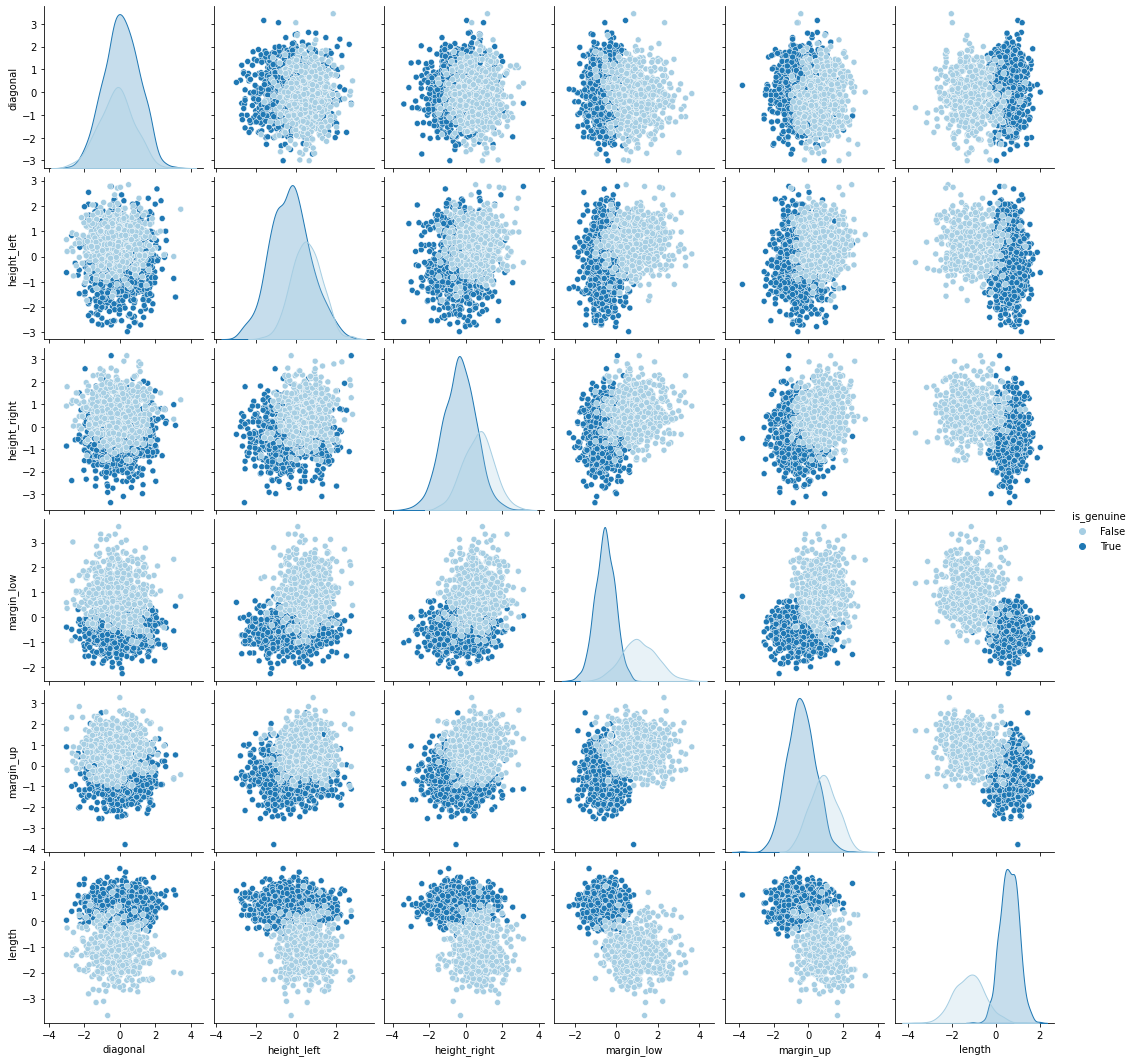

In [65]:
# Pair plot:
sns.pairplot(billetsS, hue="is_genuine", palette="Paired")

Les dimensions qui permettent vraiment de distinguer les vrais des faux billets sont length et margin_low. (On peut distinguer deux classes bien séparées). 

## <a name="C13">3.Analyse en composantes principales </a> 

### Tester statistiquement si la compression des variables est pertinente

In [66]:
# hypothèse nulle : orthogonalité des variables
# hypothèse alternative : les variables sont corrélées
R = billetsS[['diagonal','height_left','height_right','margin_low','margin_up','length']].corr()
# Mise en œuvre du test de sphéricité  de Bartlett
n= billetsS[['diagonal','height_left','height_right','margin_low','margin_up','length']].shape[0]
p= billetsS[['diagonal','height_left','height_right','margin_low','margin_up','length']].shape[1]
Khi2= -(n-1-(2*p+5)/6)*mt.log(np.linalg.det(R))
ddl= p*(p-1)/2
P_valeur = chi2.pdf(Khi2,ddl)
print(P_valeur<0.01)

True


### Data

In [67]:
XACP = billetsS.copy(deep=True)
XACP = XACP[['diagonal','height_left','height_right','margin_low','margin_up','length']]

### ACP

In [68]:
#ACP
# les composantes
n_components = 6
# On instancie notre ACP
pca = PCA(n_components = n_components)
# On l'entraine 
pca.fit(XACP)

PCA(n_components=6)

### Explained variance & scree plot

In [69]:
# La variance captée par chaque nouvelle composante.
pca.explained_variance_ratio_
# Enregister cela dans une variable
scree = (pca.explained_variance_ratio_*100).round(2)
# La somme cumulée de la variance
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

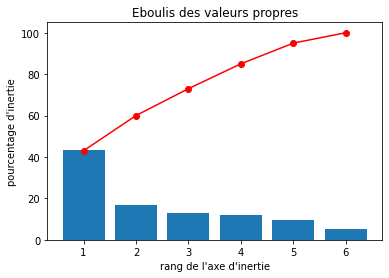

In [70]:
# La liste des composantes
x_list = range(1, n_components+1)
# Affichage
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

### Les composantes

In [71]:
# Choix de nombre de composantes
n_components = 2
pca = PCA(n_components = n_components)
pca.fit(XACP)
# La liste des composantes
x_list = range(1, n_components+1)
list(x_list)

[1, 2]

In [72]:
# Corrélations  entre les variables initiales et les variables synthétiques
pcs = pca.components_
# Version pandas
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.39,0.50,0.44,-0.53
F2,0.94,0.31,0.11,-0.07,-0.01,0.05


<AxesSubplot:>

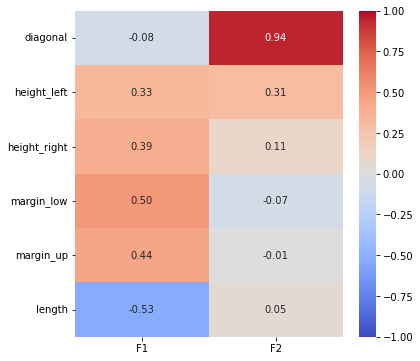

In [73]:
# Représentation plus visuelle des corrélations
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [74]:
# Fonction pour visualiser le cercle de corrélations
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] ,
                pca.components_[y, i] ,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

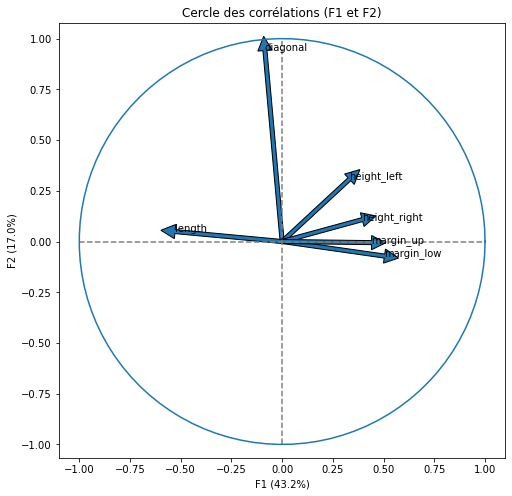

In [75]:
# Visualisation de corrélations sur le premier plan factoriel
x_y = (0,1)
correlation_graph(pca, x_y, features)

<div class="alert alert-block alert-info">
F1 synthétise notamment les variables length, margin_low et margin_up.<br>
F2 synthétise la dimension diagonale.
</div>  

### Projection

In [76]:
# Les coordonnées des individus dans le nouvel espace 
X_proj = pca.transform(XACP)
X_proj[:5]

array([[ 1.64838016,  0.74508932],
       [-2.01692351, -2.20684806],
       [-0.97065754,  2.62158881],
       [-1.37056781, -1.81953473],
       [ 0.15431648, -0.56827285]])

In [77]:
# Fonction Visualise la projection de individus 
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=None, 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en un df
    X_ = pd.DataFrame(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # On définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On rajoute la color, les clusters et les labels à X_
    X_["clusters"] =  clusters if clusters is not None else "None" 
    X_["labels"] =  labels if labels is not None else "None"
    c_unique_list = X_["clusters"].sort_values().unique()
    c_dict = {j:i+1 for i, j in enumerate(c_unique_list)}
    X_["colors"] = X_["clusters"].apply(lambda i : c_dict[i])

    # Pour chaque couleur / cluster
    for c in sorted(X_.clusters.unique()) : 
        # On selectionne le sous DF
        sub_X =X_.loc[X_.clusters == c, : ]

        # Clusters and color
        cluster = sub_X.clusters.iloc[0]
        color = sub_X.colors.iloc[0]

        # On affiche les points
        ax.scatter(    sub_X.iloc[:, x], 
                        sub_X.iloc[:, y], 
                        alpha=alpha, 
                        label = cluster ,
                        cmap="Set1", 
                        marker=marker)
        
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_.iloc[:, x]).max() *1.1
    y_max = np.abs(X_.iloc[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='black', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='black', alpha=0.8)

    country_coor = []
    


    # Affichage des labels des points
    if labels is not None:  
        for i,(_x,_y) in enumerate(X_projected[:,[x,y]]):
            plt.text(_x, _y, labels[i], fontsize='14', ha='center',va='center') 

    # Titre, legend et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    if clusters is not None: 
        plt.legend()
    plt.show()

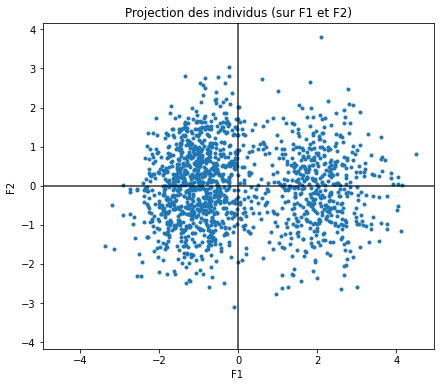

In [78]:
# Affichage de la projection des individus sur le plan(F1,F2)
x_y = (0,1)
display_factorial_planes(X_proj, x_y)

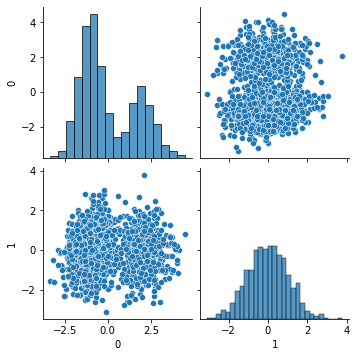

In [79]:
X_proj = pd.DataFrame(X_proj)
sns.pairplot(X_proj)

<div class="alert alert-block alert-info">
On observe très bien que la composante F1 permet de distinguer les faux de vrais billets.<br>
Ainsi la variable length, margin_low et margin_up sont les plus censées à classifier les billets en faux et vrais.
</div>  

## **Partie3: Identification des contrefaçons des billets**
## <a name="C14">1.Identification des contrefaçons par la méthode K-means</a> 

In [80]:
def confusion(y_test, y_predected) :
    """display a confusion matrix"""
    mat = confusion_matrix(y_test, y_predected)
    mat = pd.DataFrame(mat)
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

#### Classification des billets par K-means et évaluation du modèle

Performances
accuracy_score: 0.9766666666666667
              precision    recall  f1-score   support

 class False       0.97      0.96      0.97       105
  class True       0.98      0.98      0.98       195

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



Text(0.5, 1.0, 'Matrice de confusion K-means\n')

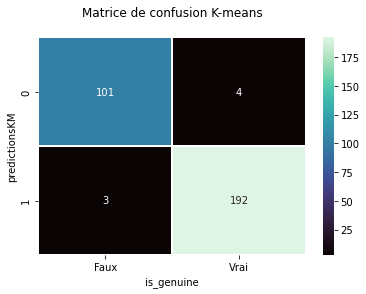

In [83]:
# Préparer les données d’entrainement
X = billetsS.iloc[:,:6]
y = billetsS.iloc[:,6]

# Division de la base de données
X_trainKM, X_testKM, y_trainKM, y_testKM = train_test_split(X, y, test_size=0.2, random_state=45)

# Création du modèle
model_kmeans = KMeans(n_clusters= 2,random_state=100 )

# On entraine
model_kmeans.fit(X_trainKM)

# Test model 
predictionsKM = model_kmeans.predict(X_testKM)

# Une condition pour forcer de donner 1 pour un vrai billet et 0 pour un faux (une solution de contournement)
Df = pd.DataFrame()
Df["predictionsKM"] = predictionsKM
if len(Df.loc[Df["predictionsKM"]== 0])>= len(Df.loc[Df["predictionsKM"]== 1]):
    Df["predictionsKM"]=Df["predictionsKM"].map({1:0, 0:1})
predictionsKM = Df["predictionsKM"]
Df["is_genuine"] = np.array(y_testKM).astype('str')
Df["is_genuine"] = Df["is_genuine"].map({'False':0, 'True':1})

# Evaluation de la classification par la méthode K-means
# matrice de confusion
Mat_confusion = confusion(y_testKM, predictionsKM)

# Performances
print('Performances')
print('===============================================================')
print('accuracy_score:',accuracy_score(y_testKM, predictionsKM))
print('===============================================================')
target_names = ['class False', 'class True']
print(classification_report(Df['is_genuine'],Df["predictionsKM"], target_names=target_names))
print('===============================================================')

# Graphique:
sns.heatmap(Mat_confusion,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("is_genuine")
plt.ylabel("predictionsKM")
plt.title("Matrice de confusion K-means\n")

#### Visualisation de la partition prédite et de la vraie partition

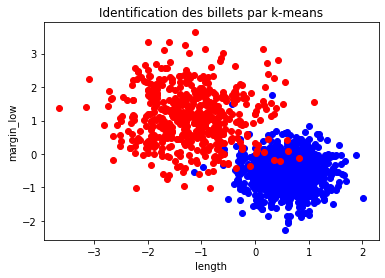

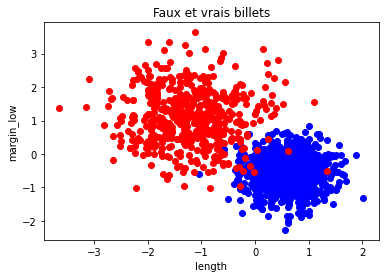

In [84]:

## Visualisation de la classification par K-means
billets_kmeans = billetsS.copy(deep = True)
model_kmeans.fit(X)
billets_kmeans['prédiction'] = model_kmeans.labels_
if len(billets_kmeans.loc[billets_kmeans["prédiction"]== 0])>= len(billets_kmeans.loc[billets_kmeans["prédiction"]== 1]):
    billets_kmeans["prédiction"] = billets_kmeans["prédiction"].map({1:0, 0:1})
df1 = billets_kmeans[billets_kmeans['prédiction'] == 1]# DataFrame de billets prédits comme vrais billets
df2 = billets_kmeans[billets_kmeans['prédiction'] == 0]# DataFrame de billets prédits comme faux billets
# Plot
plt.scatter(df1['length'], df1['margin_low'], color='blue',  label='True')
plt.scatter(df2['length'], df2['margin_low'], color= 'red', label='False')

plt.xlabel('length')
plt.ylabel('margin_low')
plt.title('Identification des billets par k-means')
plt.show()
## Visualisation de la vrai classification
df3 = billetsS[billetsS['is_genuine'] == True] # DataFrame de vrais billets
df4 = billetsS[billetsS['is_genuine'] == False]# DataFrame de faux billets
# Plot
plt.scatter(df3['length'], df3['margin_low'], color='blue',  label='True')
plt.scatter(df4['length'], df4['margin_low'], color= 'red', label='False')

plt.xlabel('length')
plt.ylabel('margin_low')
plt.title('Faux et vrais billets')
plt.show()

## <a name="C15">2. Classification par l’algorithme K Nearest Neighbors Knn</a> 

L’algorithme K Nearest Neighbors (K-NN) est un algorithme d’apprentissage supervisé.<br>
Pour effectuer une prédiction, l’algorithme K-NN ne va pas calculer un modèle prédictif à partir d’un Training Set comme c’est le cas pour la régression logistique ou la régression linéaire. En effet, K-NN n’a pas besoin de construire un modèle prédictif. Ainsi, pour K-NN il n’existe pas de phase d’apprentissage proprement dite.<br>

Pour effectuer une prédiction, l’algorithme K-NN va se baser sur le jeu de données en entier. En effet, pour une observation, qui ne fait pas parti du jeu de données, qu’on souhaite prédire, l’algorithme va chercher les K instances du jeu de données les plus proches de notre observation.<br>


In [85]:
# les prédicteurs et la variable target
XKNN = billetsS.iloc[:,:6]
yKNN = billetsS.iloc[:,6]
# Division de la base de données
X_trainKNN,X_testKNN, y_trainKNN, y_testKNN = train_test_split(XKNN, yKNN, test_size=0.2, random_state=45)

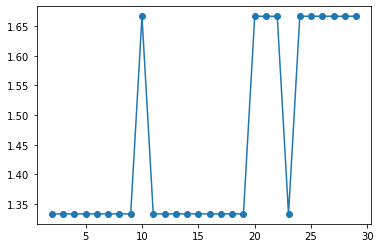

In [86]:
# Choix de k pour minimiser l'erreur
errors = []
for k in range(2,30):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_trainKNN, y_trainKNN).score(X_testKNN, y_testKNN)))
plt.plot(range(2,30), errors, 'o-')
plt.show()

In [87]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(4)
knn.fit(X_trainKNN, y_trainKNN)
error = 1 - knn.score(X_testKNN, y_testKNN)
print('Erreur: %f' % error)

# On récupère les prédictions sur les données test
predictedKnn = knn.predict(X_testKNN)
Evaluation = pd.DataFrame()
Evaluation['y_predKNN'] = predictedKnn
Evaluation['y_testKNN'] = np.array(y_testKNN)
Evaluation

Erreur: 0.013333


,y_predKNN,y_testKNN
0,True,True
1,True,True
2,True,True
3,False,False
4,True,True
...,...,...
295,False,False
296,True,True
297,False,False
298,True,True


In [88]:
confusion(Evaluation['y_testKNN'],Evaluation['y_predKNN'])

,0,1
test_0,101,4
test_1,0,195


## <a name="C16">3. Classification par régression logistique </a>

La régression logistique est une approche statistique qui peut être employée pour évaluer et caractériser les relations entre une variable réponse de type binaire , et une, ou plusieurs, variables explicatives, qui peuvent être de type catégoriel , ou numérique continu.<br>
Dans la régression logistique on modélise la probabilité de réalisation d’une des deux modalités.<br>
Cette probabilité, est modélisée par une courbe sigmoïde, bornée par 0, et 1 <br>
P(y)=exp(β0+β1X1+…+βnXn)/1+exp(β0+β1X1+…+βnXn)=exp(∑βX)/1+exp(∑βX).<br>
Tout le problème de classification par régression logistique apparaît alors comme un simple problème d’optimisation où, à partir de données, nous essayons d’obtenir le meilleur jeu de paramètre permettant à notre courbe sigmoïde de coller au mieux aux données.<br> 
Pour obtenir un modèle linéaire, il est nécessaire de passer par une transformation logit :
logit(p)=log(p/1−p)=∑j1nβjXij<br>

### <a name="C18">3.1 Visualisation </a>

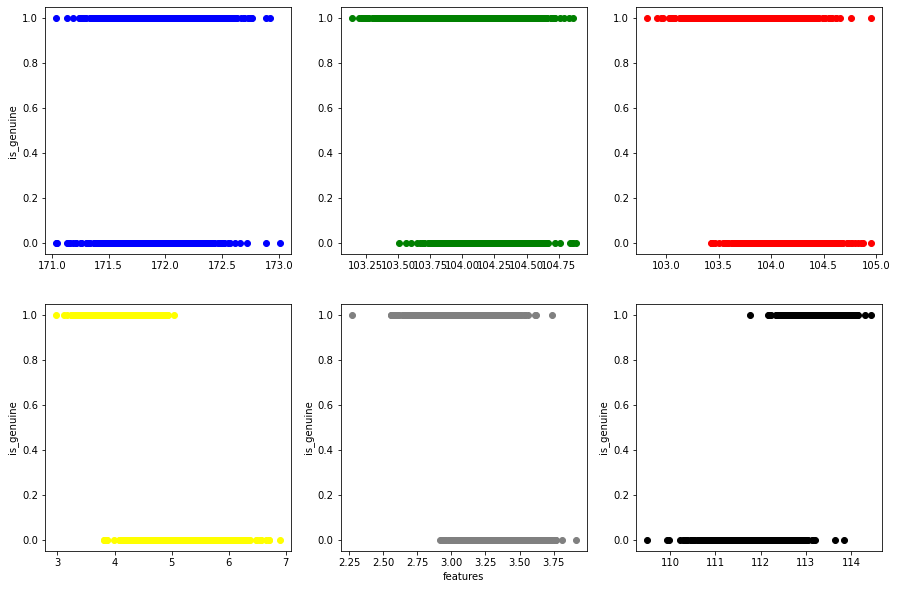

In [89]:
# La variable réponse en fonction de variables explicatives
fig= plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.ylabel('is_genuine')
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'diagonal']
plt.scatter(pltY, pltX, color='blue', label='diagonal')

plt.subplot(2, 3, 2)
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'height_left']
plt.scatter(pltY, pltX, color='green', label='height_left')

plt.subplot(2, 3, 3)
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'height_right']
plt.scatter(pltY, pltX, color='red')

plt.subplot(2, 3, 4)
plt.ylabel('is_genuine')
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'margin_low']
plt.scatter(pltY, pltX, color='yellow')

plt.subplot(2, 3, 5)
plt.xlabel('features')
plt.ylabel('is_genuine')
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'margin_up']
plt.scatter(pltY, pltX, color='gray', label='margin_up')

plt.subplot(2, 3, 6)
plt.ylabel('is_genuine')
pltX = Billets.loc[ :,'is_genuine']
pltY = Billets.loc[ :,'length']
plt.scatter(pltY, pltX, color='black', label='length')

### <a name="C18">3.2 Régression logistique après la suppression des lignes avec des valeurs Nan</a>

              precision    recall  f1-score   support

       False       1.00      0.99      0.99        99
        True       0.99      1.00      1.00       194

    accuracy                           1.00       293
   macro avg       1.00      0.99      1.00       293
weighted avg       1.00      1.00      1.00       293

0.9965870307167235


Text(0.5, 1.0, 'Matrice de confusion')

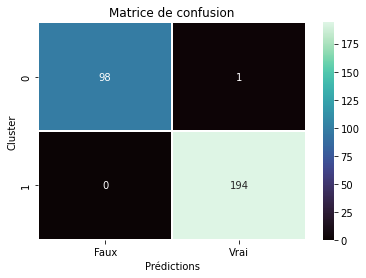

In [90]:
# Préparer les données d’entrainement
XNan = BillesSansLignesNan.iloc[ :, 1:]
yNan = BillesSansLignesNan.iloc[ :,0]

# Division de la base de données
X_trainNan,X_testNan, y_trainNan, y_testNan = train_test_split(XNan, yNan, test_size=0.2, random_state=45)

# Centrer et reduire
scalerNan = StandardScaler()
X_trainNan = scalerNan.fit_transform(X_trainNan)
X_testNan = scalerNan.fit_transform(X_testNan)

# Création du modèle
modelNan = LogisticRegression()
# Entrainement de modèle sur les données d'entrainement
modelNan.fit(X_trainNan,y_trainNan)

# Test model 
predictionRLogNan = modelNan.predict(X_testNan)

# Evaluation du model
print(classification_report(y_testNan,predictionRLogNan))
print(accuracy_score(y_testNan,predictionRLogNan))
# matrice de confusion
Mat_confusionNan = confusion_matrix(y_testNan,predictionRLogNan)

# Graphique:
sns.heatmap(Mat_confusionNan,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion")

### <a name="C19">3.3 Régression logistique cas ou les valeurs manquantes sont imputées par la moyenne</a>

              precision    recall  f1-score   support

       False       1.00      0.97      0.99       105
        True       0.98      1.00      0.99       195

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

0.99


Text(0.5, 1.0, 'Matrice de confusion')

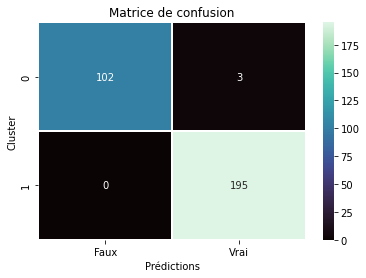

In [91]:
# Préparer les données d’entrainement
XM = BilletsMoyenne.iloc[ :, 1:]
yM = BilletsMoyenne.iloc[ :,0]

# Division de la base de données
X_trainM, X_testM, y_trainM, y_testM = train_test_split(XM, yM, test_size=0.2, random_state=45)

# Centrer et reduire
scalerMoy = StandardScaler()
X_trainM = scalerMoy.fit_transform(X_trainM)
X_testM = scalerMoy.fit_transform(X_testM)
# Création du modèle
modelM = LogisticRegression()
modelM.fit(X_trainM,y_trainM)

# Test model 
predictionRLogMoy = modelM.predict(X_testM)

# Evaluation du model

print(classification_report(y_testM,predictionRLogMoy))
print(accuracy_score(y_testM,predictionRLogMoy))
Mat_confusionM = confusion(y_testM,predictionRLogMoy)
# Graphique:
sns.heatmap(Mat_confusionM,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion")

### <a name="C20">3.4 Régression logistique cas ou valeurs manquantes imputées grace à une régresssion logistique</a>
#### <a name="C21">3.4.1 Régression logistique avec statsmodels et analyse des résultats statistiques</a>

In [92]:
# defining the dependent and independent variables
X = billetsS.iloc[ :,:6]
y = billetsS.iloc[ :, 6]
X = sm.tools.add_constant(X) #Il faut ajouter une constante dans Statsmodels
# building the model and fitting the data
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Sun, 22 Jan 2023   Pseudo R-squ.:                  0.9557
Time:                        17:30:35   Log-Likelihood:                -42.342
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2546      0.365      6.180      0.000       1.540       2.970
diagonal         0.020

<div class="alert alert-block alert-info">
    
**LLR p-value** est inférieure à 0.05, le modèle est significatif dans son ensemble (ceci signifie qu’il y a au moins un prédicteur du modèle qui est associé significativement à la variable dépendante).<br>

**Le pseudo R²** représente la proportion de la probabilité expliquée par l’amélioration du modèle. Sa valeur varie entre 0 et 1. Le pseudo R² est très proche de 1.<br>

**coef** : Ces coefficients constituent les paramètres d’estimation de la probabilité maximale (maximum-likelihood :Les valeurs prédites de Y situées le plus près possible des valeurs observées) et mesurent le changement du ratio de probabilité (odds ratio).<br>  
Un odds ou cote est le rapport de deux probabilités complémentaires : la probabilité P de survenue d’un événement , divisé par la probabilité (1-P) que cet événement ne survienne pas.<br>

Un coefficient issus de la régression logistique est un log odds ratio consécutive à l’augmentation d’une unité de la variable explicative.<br>
On a des log d'OR de certains variables  non-significatives au seuil alpha 5 % (diagonal et height_left) .Si on prend alpha 1 %, on enlèvera height_right en plus. On recommence la régression sans ces variables (diagonal, height_left).
</div> 

In [93]:
## On rétire la variable diagonal de notre modèle
X1 = billetsS.iloc[ :,1:6]
y1 = billetsS.iloc[ :, 6]
X1 = sm.tools.add_constant(X1)
# building the model and fitting the data
log_reg1 = sm.Logit(y1, X1).fit()
# printing the summary table
print(log_reg1.summary())
print('==============================================================================================')


Optimization terminated successfully.
         Current function value: 0.028230
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1494
Method:                           MLE   Df Model:                            5
Date:                Sun, 22 Jan 2023   Pseudo R-squ.:                  0.9556
Time:                        17:30:36   Log-Likelihood:                -42.344
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2551      0.365      6.183      0.000       1.540       2.970
height_left     -0.513

In [94]:
## On ne garde que les variables significatives à alpha = 5% 
X2 = billetsS.iloc[ :,2:6]
y2 = billetsS.iloc[ :, 6]
X2 = sm.tools.add_constant(X2)
# building the model and fitting the data
log_reg2 = sm.Logit(y2, X2).fit()
# printing the summary table
print(log_reg2.summary())
print('==============================================================================================')
print('==============================================================================================')
print(log_reg2.summary2())

Optimization terminated successfully.
         Current function value: 0.029058
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1495
Method:                           MLE   Df Model:                            4
Date:                Sun, 22 Jan 2023   Pseudo R-squ.:                  0.9543
Time:                        17:30:36   Log-Likelihood:                -43.586
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2446      0.358      6.266      0.000       1.543       2.947
height_right    -0.906


**Les coefficients** :<br> 
ln [P(événement)/P(non événement)] = β0 + β1x1 + β2x2 + ... + βnxn<br>
Plus le logarithme des probabilités de succès est important, plus l'événement de référence(le billet est vrai) est probable. Ainsi, des coefficients positifs indiquent que la probabilité de l'événement augmente, tandis que des coefficients négatifs indiquent qu'elle diminue.<br>

Le log des cotes n'est pas intuitif dans son interprétation. Convertissons cela en rapport de cotes(OR) et interprétons à nouveau le modèle. Pour convertir les coefficients de probabilité logarithmique il faut prendre l'exponentielle des valeurs.<br>

L'OR représente les chances qu'un résultat se produise compte tenu d'un événement particulier, par rapport aux chances que le résultat se produise en l'absence de cet événement. Si l'OR est supérieur à 1, l'événement est associé à une probabilité plus élevée de générer un résultat spécifique. Inversement, si l'OR est inférieur à 1, l'événement est associé à une probabilité plus faible que ce résultat se produise.

OR = 1, mêmes cotes<br>
OR < 1, moins/diminution des cotes<br>
OR > 1, plus grand/augmentation des cotes<br>

In [95]:
# convertir les coefficients de probabilité logarithmique 
model_odds = pd.DataFrame(np.exp(log_reg2.params), columns= ['OR'])
model_odds['z-value']= log_reg2.pvalues
model_odds

,OR,z-value
const,9.436767,3.696511e-10
height_right,0.404056,9.803182e-03
margin_low,0.018418,1.919526e-11
margin_up,0.093907,9.097944e-07
length,184.907605,4.578121e-13


<div class="alert alert-block alert-info">
Les variables explicatives sont numériques continues, dans cette situation, on n’interprète pas la valeur de l’OR.
On regarde le signe de l’OR, et s’il est significativement différent de 1 (pvalue du log OR <0.05).<br>
    
Il existe une association significative entre length et la chance que le billet soit vrai, avec un risque de 5% de se tromper, La chance que le billet soit vrai augmente lorsque length augmente.<br>

Il existe une association significative entre les autres variables (height_right,margin_low,margin_up) et la chance que le billet soit vrai, avec un risque de 5% de se tromper, La chance que le billet soit vrai diminue lorsque ces dimensions augmentent.<br>
</div>  

In [96]:
# lien pour interpréter les coefficients 
webbrowser.open('https:delladata.fr/regression-logistique/')

True

In [97]:
# Vérification de nos'interprétations par le calcul
print("La langueur moyenne de vrais billets est", round(Billets[Billets['is_genuine'] == True]['length'].mean(),2)) 
print("La langueur moyenne de faux billets est", round(Billets[Billets['is_genuine'] == False]['length'].mean(),2))
print('==================================================================')
print("La moyenne de la variable margin_up de vrais billets est", 
      round(Billets[Billets['is_genuine'] == True]['margin_up'].mean(),2))
print("La moyenne de la variable margin_up de Faux billets est",
      round(Billets[Billets['is_genuine'] == False]['margin_up'].mean(),2))
print('==================================================================')
print("La moyenne de la variable height_right de vrais billets est",
      round(Billets[Billets['is_genuine'] == True]['height_right'].mean(),2))
print("La moyenne de la variable height_right de Faux billets est",
      round(Billets[Billets['is_genuine'] == False]['height_right'].mean(),2))
print('==================================================================')
print("La moyenne de la variable margin_low de vrais billets est",
      round(Billets[Billets['is_genuine'] == True]['margin_low'].mean(),2))
print("La moyenne de la variable margin_low de Faux billets est",
      round(Billets[Billets['is_genuine'] == False]['margin_low'].mean(),2))


La langueur moyenne de vrais billets est 113.2
La langueur moyenne de faux billets est 111.63
La moyenne de la variable margin_up de vrais billets est 3.05
La moyenne de la variable margin_up de Faux billets est 3.35
La moyenne de la variable height_right de vrais billets est 103.81
La moyenne de la variable height_right de Faux billets est 104.14
La moyenne de la variable margin_low de vrais billets est 4.12
La moyenne de la variable margin_low de Faux billets est 5.22


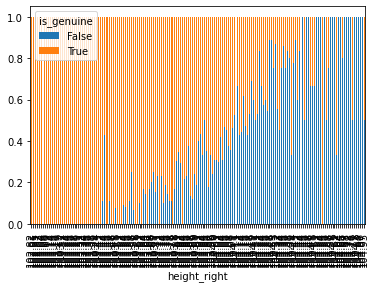

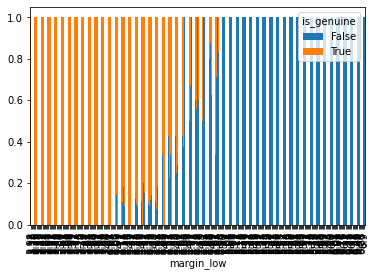

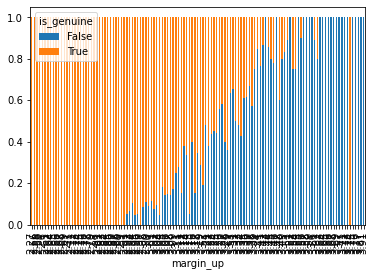

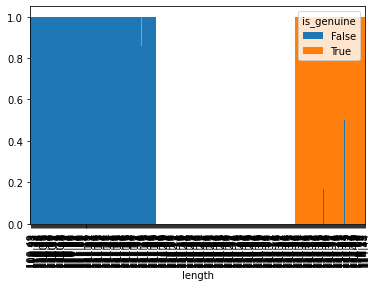

In [98]:
# Vérification visuelle de interpétations
variable_list = ['height_right','margin_low','margin_up','length']
for variable in variable_list:
    table = pd.crosstab(Billets[variable],Billets.is_genuine)
    table.div(table.sum(1).astype(float),axis =0).plot(kind = 'bar',stacked = True)

### <a name="C22">3.4.2 Logistic Regression Assumptions</a>

**Assumption 1 - Appropriate outcome type**<br>
 La régression logistique binaire exige que la variable dépendante soit binaire.

In [99]:
# Appropriate outcome type
billetsS['is_genuine'].unique()

array([ True, False])

**Assumption 2 - Linearity of independent variables and log odds**<br>
La régression logistique suppose la linéarité des variables indépendantes et des cotes logarithmiques.<br>
La transformation de Box-Tidwell (test) peut être utilisée pour tester l'hypothèse de la linéarité.<br>
Une valeur p statistiquement significative du terme d'interaction dans la transformation de Box-Tidwell signifie que l'hypothèse de linéarité est violée.<br>

In [100]:
# Box Tidwell only works for positive values. Hence, drop values where x <= 0
df_billets = billetsS.drop(billetsS[billetsS.margin_up <= 0].index)
df_billets = df_billets.drop(df_billets[df_billets.margin_low <= 0].index)
df_billets = df_billets.drop(df_billets[df_billets.height_right<= 0].index)
df_billets = df_billets.drop(df_billets[df_billets.length<= 0].index)
df_billets.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
310,1.676733,-0.532911,0.736343,0.217052,0.123100,0.345583,True
341,-0.191548,0.602838,0.889944,0.428027,0.986152,0.597750,True
416,1.578402,0.268794,1.012825,0.066356,0.123100,0.838454,True
428,-0.322655,-0.866955,0.029778,0.518445,0.079947,0.769681,True
430,0.529543,0.168581,0.029778,0.352679,0.123100,0.804068,True


In [101]:
df_billets_lt = df_billets[['height_right','margin_low','margin_up','length','is_genuine']].copy()  # lt = logit transform

# Define continuous variables
variable_list = ['height_right','margin_low','margin_up','length']

# Add logit transform interaction terms (natural log) for continuous variables
for var in variable_list:
    df_billets_lt[f'{var}:Log_{var}'] = df_billets_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log
# Display
df_billets_lt.head()


,height_right,margin_low,margin_up,length,is_genuine,height_right:Log_height_right,margin_low:Log_margin_low,margin_up:Log_margin_up,length:Log_length
310,0.736343,0.217052,0.123100,0.345583,True,-0.225364,-0.331573,-0.257865,-0.367190
341,0.889944,0.428027,0.986152,0.597750,True,-0.103764,-0.363210,-0.013752,-0.307592
416,1.012825,0.066356,0.123100,0.838454,True,0.012907,-0.180005,-0.257865,-0.147732
428,0.029778,0.518445,0.079947,0.769681,True,-0.104640,-0.340578,-0.201978,-0.201486
430,0.029778,0.352679,0.123100,0.804068,True,-0.104640,-0.367561,-0.257865,-0.175344


In [102]:
# Keep columns related to continuous variables
cols_to_keep = variable_list + df_billets_lt.columns.tolist()[-len(variable_list):]
cols_to_keep

['height_right',
 'margin_low',
 'margin_up',
 'length',
 'height_right:Log_height_right',
 'margin_low:Log_margin_low',
 'margin_up:Log_margin_up',
 'length:Log_length']

In [103]:
# Redefine independent variables to include interaction terms
X_lt = df_billets_lt[cols_to_keep]
y_lt = df_billets_lt['is_genuine']

# Add constant
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

PerfectSeparationError: Perfect separation detected, results not available

<div class="alert alert-block alert-danger">
En raison de la séparation parfaite, notre modèle ne peut pas converger. Une séparation parfaite signifie qu'il y a une (ou plusieurs) variable dans nos variables indépendantes qui peuvent parfaitement distinguer la variable dépendante = 0 de la variable dépendante = 1.<br>
D'après les graphiques et les analyses précédentes la variable length permet de séparer les billets ainsi on va enléver la variable length.
</div>

In [104]:
df_billets_lt = df_billets[['height_right','margin_low','margin_up','is_genuine']].copy()  # lt = logit transform

# Define continuous variables
variable_list = ['height_right','margin_low','margin_up']

# Add logit transform interaction terms (natural log) for continuous variables 
for var in variable_list:
    df_billets_lt[f'{var}:Log_{var}'] = df_billets_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_billets_lt.head()

,height_right,margin_low,margin_up,is_genuine,height_right:Log_height_right,margin_low:Log_margin_low,margin_up:Log_margin_up
310,0.736343,0.217052,0.123100,True,-0.225364,-0.331573,-0.257865
341,0.889944,0.428027,0.986152,True,-0.103764,-0.363210,-0.013752
416,1.012825,0.066356,0.123100,True,0.012907,-0.180005,-0.257865
428,0.029778,0.518445,0.079947,True,-0.104640,-0.340578,-0.201978
430,0.029778,0.352679,0.123100,True,-0.104640,-0.367561,-0.257865


In [105]:
# Keep columns related to continuous variables
cols_to_keep = variable_list + df_billets_lt.columns.tolist()[-len(variable_list):]
cols_to_keep

['height_right',
 'margin_low',
 'margin_up',
 'height_right:Log_height_right',
 'margin_low:Log_margin_low',
 'margin_up:Log_margin_up']

In [106]:
# Redefine independent variables to include interaction terms
X_lt = df_billets_lt[cols_to_keep]
y_lt = df_billets_lt['is_genuine']

# Add constant
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

PerfectSeparationError: Perfect separation detected, results not available

<div class="alert alert-block alert-danger">
Pareil, en raison de la séparation parfaite, notre modèle ne peut pas converger. 
On va enléver la variable margin_low.
</div>


In [107]:
df_billets_lt = df_billets[['height_right','margin_up','is_genuine']].copy()  # lt = logit transform

# Define continuous variables
variable_list = ['height_right','margin_up']

# Add logit transform interaction terms (natural log) for continuous variables
for var in variable_list:
    df_billets_lt[f'{var}:Log_{var}'] = df_billets_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_billets_lt.head()

,height_right,margin_up,is_genuine,height_right:Log_height_right,margin_up:Log_margin_up
310,0.736343,0.123100,True,-0.225364,-0.257865
341,0.889944,0.986152,True,-0.103764,-0.013752
416,1.012825,0.123100,True,0.012907,-0.257865
428,0.029778,0.079947,True,-0.104640,-0.201978
430,0.029778,0.123100,True,-0.104640,-0.257865


In [108]:
# Keep columns related to continuous variables
cols_to_keep = variable_list + df_billets_lt.columns.tolist()[-len(variable_list):]
cols_to_keep

['height_right',
 'margin_up',
 'height_right:Log_height_right',
 'margin_up:Log_margin_up']

In [109]:
# Redefine independent variables to include interaction terms
X_lt = df_billets_lt[cols_to_keep]
y_lt = df_billets_lt['is_genuine']

# Add constant
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                   30
Model:                            GLM   Df Residuals:                       25
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11.194
Date:                Sun, 22 Jan 2023   Deviance:                       22.388
Time:                        17:31:13   Pearson chi2:                     21.1
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
height_right  

Selon le test de Box-Tidewell, si le coefficient Z est significatif pour les log_x cela signifie que la variable x intervient de manière non-linéaire sur le logit. On regarde donc les p-value pour les log_x.
Pour log_margin_up et log_height_right, la p-value de Z est supérieure à 0,05, l'hypothèse nulle de linéarité ne peut pas être rejetée.

 
 </div> <div class="alert alert-block alert-warning"> Les variables length et margin_low séparent parfaitement les données. Normalment on peut les transformer à des variables categorielles.<br>
Pour length on aura deux groupes (billet_long, billet_court) ainsi length sera une variable binaire.<br>
Pour margin_low on aura trois groupes (margin_low_petit, margin_low_moyen, margin_low_grand) ainsi la variable margin_low sera une variable qualitative avec trois modalités. (Regardez les graphiques en dessous de cette paragraphe)<br>
Si on transforme length et margin_low en categorielles il nous faut faire après une étape de préparation des données:
<ul>
  <li>Pour la variable binaire length il nous suffit de les recoder avec Scikit-Learn pour obtenir des données exploitables.On peut utiliser LabelEncoder pour transformer les valeurs textuelles en entiers</li>
  <li>Pour la variable margin_low avec trois modalité on utilise LabelEncoder pour la transformer en entiers puis on utilise la classe OneHotEncoder afin de transformer la colonne margin_low en trois colonnes binaires.</li>
  </ul>
On applique à ces variables qualitatives une OneHot et une transformation avec StandardScaler pour les variables quantitative (height_right et margin_up).<b>

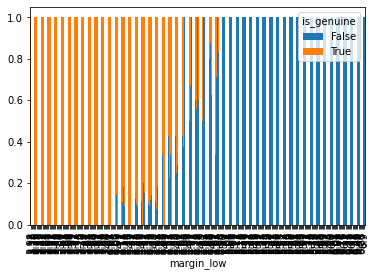

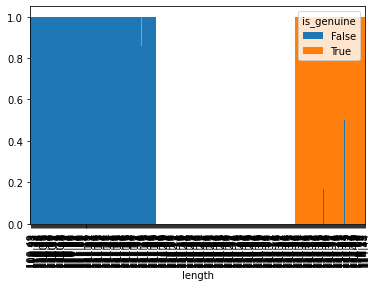

In [110]:
# Vérification visuelle
variable_list = ['margin_low','length']
for variable in variable_list:
    table = pd.crosstab(Billets[variable],Billets.is_genuine)
    table.div(table.sum(1).astype(float),axis =0).plot(kind = 'bar',stacked = True)

### Visual check of Linearity assumption

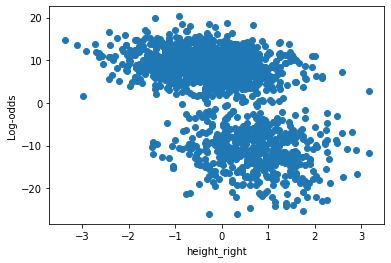

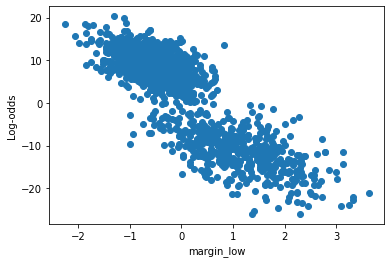

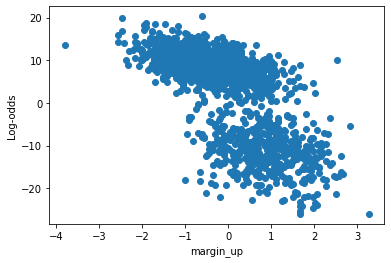

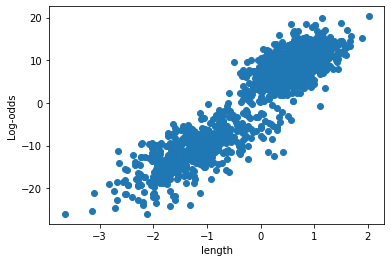

In [111]:
# Re-run logistic regression on original set of X and y variables
log_reg2 = GLM(y2, X2, family=families.Binomial()).fit()
predicted = log_reg2.predict(X2)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values 
variable_list = ['height_right','margin_low','margin_up','length']
for variable in variable_list:
    plt.scatter(x=X2[variable].values, y=log_odds);
    plt.xlabel(variable)
    plt.ylabel("Log-odds")
    plt.show()


#### Assumption 3 - No strongly influential outliers

In [112]:
# building the model and fitting the data
log_reg3 = GLM(y2, X2,family=families.Binomial()).fit()
print(log_reg3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.586
Date:                Sun, 22 Jan 2023   Deviance:                       87.173
Time:                        17:31:18   Pearson chi2:                 3.24e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2446      0.358      6.266   

In [113]:

from scipy import stats

# Get influence measures
influence = log_reg3.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(log_reg3.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()

,cooks_d,std_resid
0,1.443531e-03,0.188781
1,4.466100e-11,0.018903
2,4.088791e-09,0.024282
3,5.060989e-13,0.017293
4,1.973192e-03,0.263415


In [114]:
# Set Cook's distance threshold
cook_threshold = 4 /(len(X2)-4)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.00267379679144385


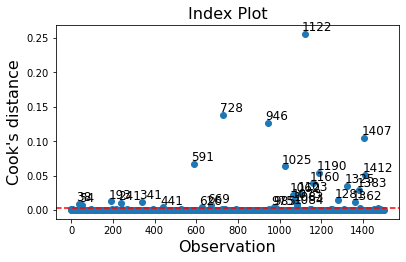

In [115]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)


In [116]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X2)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 1.9%


In [117]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme)/ len(X2)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 0.2%


In [118]:
# Display most influential outliers
extreme.sort_values("cooks_d", ascending=False)

,cooks_d,std_resid
1122,0.256374,37.965280
728,0.138047,3.934187
1407,0.104823,3.107062


In [119]:
# Supprimer les outliers influentes
extrem_idx=extreme.index
Billet_sansOutliersInflu = billetsS.drop(extreme.index)

**Assumption 4 - Absence of multicollinearity**<br>
La régression logistique exige qu’il y ait peu ou pas de multicolinéarité entre les variables indépendantes. Cela signifie que les variables indépendantes ne doivent pas être trop fortement corrélées les unes aux autres.

In [120]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(X2) # Include constant in VIF calculation in Python


,variables,VIF
0,const,1.000027
1,height_right,1.246905
2,margin_low,1.906386
3,margin_up,1.411962
4,length,2.113826


<div class="alert alert-block alert-info">
VIF <10 Il n'y a donc pas de collinéarité
</div>    

**Assumption 5— Independence of observations**<br>
Les observations doivent être indépendantes les unes des autres, c'est-à-dire qu'elles ne doivent pas provenir de données répétées ou appariées. Cela signifie que chaque observation n'est pas influencée ou liée au reste des observations.

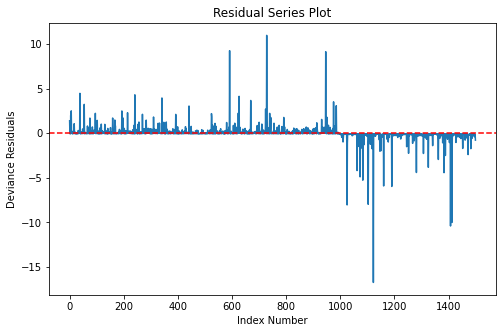

In [121]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(X.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(X2.index.tolist(), stats.zscore(log_reg2.resid_deviance))
plt.axhline(y=0, ls="--", color='red');


<div class="alert alert-block alert-info">
Les résidus jusqu'à l'index 1000 sont positifs et pour les index de 1000 jusqu'à 1500 sont négatifs.<br>
Explication:  nous prédisons une probabilité pour une variable prenant les valeurs 0 ou 1. Si la vraie valeur est 0 (False), alors nous prédisons toujours plus, et les résidus doivent être négatifs (de l'index 1000 jusqu'à 1500 sont des faux billets) et si la vraie valeur est 1, alors nous sous-estimons, et les résidus doivent être positifs (de l'index 0 jusqu'à 1000 on a des vrais billets).<br>
 </div> 
<div class="alert alert-block alert-danger">
Étant donné que les résidus dans le graphique ci-dessus semblent être dispersés de manière non aléatoire autour de la ligne médiane de zéro, nous pouvons en déduire (visuellement) que l'hypothèse est non satisfaite.
Les observations ne sont pas indépendantes les unes des autres car les données sont appariées c'est à dire groupées. 
</div>

**Assumption 6 - Sufficiently large sample size**
La régression logistique nécessite généralement une grande taille d’échantillon. En générale il faut qu'on ait au moins 10 cas avec le résultat le moins fréquent pour chaque variable indépendante de modèle.

### <a name="C23">3.4.3 Logistic regression (Scikit-learn package)</a>
### Data separation


In [122]:
X = billetsS.iloc[ :,2:6] # features
y = billetsS.is_genuine # target


### Test train split

In [123]:
# Division de la base de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")

Nous avons X_train de forme (1200, 4) et y_train de forme (1200,)
Nous avons X_test de forme (300, 4) et y_test de forme (300,)


In [124]:
def score(estimator) :
    """compute and print train scoreand test score"""
    tr_score = estimator.score(X_train,y_train).round(4)
    te_score = estimator.score(X_test,y_test).round(4)
    print(f"score train :{tr_score} score test :{te_score}")

### Modélisation: Dummy classifier (classifieur naïf )

Dans la régression logistique, le modèle de base est le plus grand nombre de cas, c’est-à-dire la catégorie (0 ou 1) qui obtient la fréquence la plus élevée. En effet, il ne serait pas judicieux d’utiliser la moyenne comme dans la régression linéaire, puisque la moyenne de 0 et de 1 ne ferait pas de sens. 

In [125]:
estimator = DummyClassifier(strategy = "most_frequent")
estimator.fit(X_train,y_train)


DummyClassifier(strategy='most_frequent')

In [126]:
y_pred = estimator.predict(X_test)

In [1007]:
pd.Series(y_pred).value_counts()

True    300
dtype: int64

In [1008]:
y_test.value_counts(normalize = True)

True     0.65
False    0.35
Name: is_genuine, dtype: float64

In [1009]:
score(estimator)

score train :0.6708 score test :0.65


<div class="alert alert-block alert-info">
La forme des données est compatible avec une modélisation.
Le DummyClassifier donne une idée du score de base que l'algorithme le plus simple obtiendrait en faisant des prédictions.
</div> 

In [1010]:
confusion(y_test,y_pred)

,0,1
test_0,0,105
test_1,0,195


### Modélisation:  Logistic regression

In [1011]:
# On instancie
estimator =  LogisticRegression()
# On fit
estimator.fit(X_train,y_train)
# prédiction
y_pred = estimator.predict(X_test)
y_proba = estimator.predict_proba(X_test).round(3)

In [1012]:
score(estimator)
confusion(y_test,y_pred)


score train :0.9908 score test :0.99


,0,1
test_0,102,3
test_1,0,195


In [1013]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)


0.99


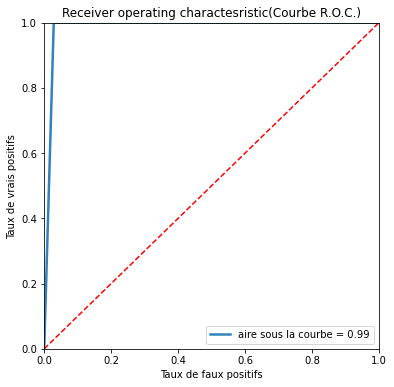

In [1014]:
# Graphique:
plt.figure(figsize=(6,6))
plt.title('Receiver operating charactesristic(Courbe R.O.C.)')
plt.plot(false_positive_rate,
        true_positive_rate,
        color="#3182bd",
        linewidth=2.5,
        label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="red", linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

### Finding hyper-parameters

In [1015]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [1016]:
# LogisticRegression instance
estimator = LogisticRegression()
clf = GridSearchCV(estimator,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [1017]:
# Entrainement
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [1018]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.9916666666666668


### Appliquer le modèle de regression logistique

In [1019]:
# On instancie
modelRLog = LogisticRegression(C = 0.1, 
                            penalty = 'l2', solver = 'liblinear')
# On fit
modelRLog.fit(X_train,y_train)
# prédiction
y_pred = modelRLog.predict(X_test)
# Evaluation
score(modelRLog)
confusion(y_test,y_pred)

score train :0.99 score test :0.99


,0,1
test_0,102,3
test_1,0,195


In [1020]:
scoreRL = modelRLog.decision_function(X_test)
dfsc = pd.DataFrame(scoreRL, columns=['score'])
dfsc['is_genuine'] = np.array(y_test)
dfsc.head()

,score,is_genuine
0,3.734096,True
1,5.872318,True
2,1.742925,True
3,-7.254511,False
4,3.707430,True


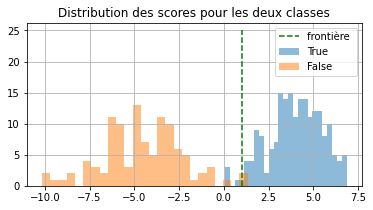

In [1021]:
ax = dfsc[dfsc['is_genuine'] == True]['score'].hist(bins=25, figsize=(6,3), label='True', alpha=0.5)
dfsc[dfsc['is_genuine'] == False]['score'].hist(bins=25, ax=ax, label='False', alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes")
ax.plot([1, 1], [0, 25], 'g--', label="frontière ")
ax.legend();

### <a name="C24">4. Les indicateurs pour valider un modèle</a> 
La partie validation d’un modèle d’apprentissage supervisé est extrêmement importante. L’objectif d’un modèle d’apprentissage supervisé est de prédire une valeur la plus proche possible de la réalité.

**Le pourcentage de bien classés**
Il s’agit de l’indicateur le plus connu. On le nomme accuracy. Il est calculé à partir du rapport entre le nombre d’individus bien classés et le nombre total d’individus dans l’échantillon.<br>
Accuracy Score = (TP + TN)/(TP + FN + TN + FP)

In [1022]:
accuracy_modele_KM = accuracy_score(y_testKM,predictionsKM)
accuracy_modele_kNN = accuracy_score(y_testKNN,predictedKnn)
accuracy_modeleRLogNan = accuracy_score(y_testNan,predictionRLogNan)
accuracy_modeleRLogMoy = accuracy_score(y_testM,predictionRLogMoy)
accuracy_modeleRLog = accuracy_score(y_test,y_pred)
print("Pourcentage de bien classés pour le modèle KM :", round(accuracy_modele_KM,4))
print("Pourcentage de bien classés pour le modèle kNN :", round(accuracy_modele_kNN,4))
print("Pourcentage de bien classés pour le modèle RLogNan :", round(accuracy_modeleRLogNan,4))
print("Pourcentage de bien classés pour le modèle RLogMoy :", round(accuracy_modeleRLogMoy,4))
print("Pourcentage de bien classés pour le modèle modeleRLog :", round(accuracy_modeleRLog,4))

Pourcentage de bien classés pour le modèle KM : 0.9767
Pourcentage de bien classés pour le modèle kNN : 0.9867
Pourcentage de bien classés pour le modèle RLogNan : 0.9966
Pourcentage de bien classés pour le modèle RLogMoy : 0.99
Pourcentage de bien classés pour le modèle modeleRLog : 0.99


**La matrice de confusion**
Il s’agit d’un autre indicateur important pour juger de la qualité d’un modèle, il n’est pas défini par une seule valeur mais par une matrice dans laquelle on peut lire le croisement entre les valeurs observées et les valeurs prédites à partir du modèle.

In [1023]:
confusion_matrix_KM = confusion_matrix(y_testKM,predictionsKM)
confusion_matrix_kNN = confusion_matrix(y_testKNN,predictedKnn)
confusion_matrix_modeleRLogNan = confusion_matrix(y_testNan,predictionRLogNan)
confusion_matrix_modeleRLogMoy = confusion_matrix(y_testM,predictionRLogMoy)
confusion_matrix_modeleRLog = confusion_matrix(y_test,y_pred)
print("Matrice de confusion pour le modèle KM :",
confusion_matrix_KM, sep="\n")
print('======================================')
print("Matrice de confusion pour le modèle knn :",
confusion_matrix_kNN, sep="\n")
print('======================================')
print("Matrice de confusion pour le modèle RLogNan :",
confusion_matrix_modeleRLogNan, sep="\n")
print('======================================')
print("Matrice de confusion pour le modèle RLogMoy :",
confusion_matrix_modeleRLogMoy, sep="\n")
print('======================================')
print("Matrice de confusion pour le modèle RLog :",
confusion_matrix_modeleRLog, sep="\n")

Matrice de confusion pour le modèle KM :
[[101   4]
 [  3 192]]
Matrice de confusion pour le modèle knn :
[[101   4]
 [  0 195]]
Matrice de confusion pour le modèle RLogNan :
[[ 98   1]
 [  0 194]]
Matrice de confusion pour le modèle RLogMoy :
[[102   3]
 [  0 195]]
Matrice de confusion pour le modèle RLog :
[[102   3]
 [  0 195]]


**Le rappel (recall), la précision et le f1-score**
Scikit-Learn possède des fonctions pour chacun de ces indicateurs, mais il peut être intéressant d’utiliser une autre fonction qui les affiche pour chaque classe :<br>

Precision Score = TP / (FP + TP)<br>
Recall Score = TP / (FN + TP)<br>
F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)<br>

In [1024]:
print("Rapport pour le modèle KM :",
      classification_report(y_testKM,predictionsKM), sep="\n")
print('=========================================')
print("Rapport pour le modèle kNN :",
      classification_report(y_testKNN,predictedKnn) ,sep="\n")
print('=========================================')
print("Rapport pour le modèle RLogNan :",
      classification_report(y_testNan,predictionRLogNan), sep="\n")
print('=========================================')      
print("Rapport pour le modèle RLogMoy :",
      classification_report(y_testM,predictionRLogMoy), sep="\n")
print('=========================================')      
print("Rapport pour le modèle RLog :",
      classification_report(y_test,y_pred), sep="\n")


Rapport pour le modèle KM :
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       105
        True       0.98      0.98      0.98       195

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300

Rapport pour le modèle kNN :
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       105
        True       0.98      1.00      0.99       195

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300

Rapport pour le modèle RLogNan :
              precision    recall  f1-score   support

       False       1.00      0.99      0.99        99
        True       0.99      1.00      1.00       194

    accuracy                           1.00       293
   macro avg       1.00      0.99     

**La courbe ROC**
Nous avons vu que lorsque les classes sont fortement déséquilibrées, la matrice de confusion est parfois dure à interpréter. La courbe ROC (Receiver Operating Characteristic) est là pour combler ce défaut. Elle est en fait la proportion de vrais positifs en fonction de la proportion de faux positifs.

Il s’agit en fait de représenter le rappel (recall) en fonction de (1- spécificité) sur une courbe en faisant varier le seuil de classification (c’est-à-dire le point à partir duquel une observation est considérée comme positive).

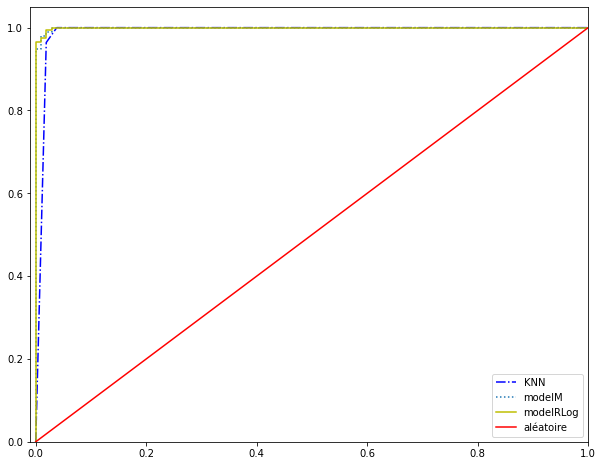

In [1025]:

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(10,8))
# on extrait les probabilités d'appartenance
proba_knn = knn.predict_proba(X_testKNN)[:,1]
proba_RLogMoy = modelM.predict_proba(X_testM)[:,1]
proba_RLog = modelRLog.predict_proba(X_test)[:,1]
# cas du modèle KNN
fpr, tpr, _ = roc_curve(y_testKNN, proba_knn)
plt.plot(fpr,tpr,"b-.", label="KNN")

# cas du modèle RLogMoy
fpr, tpr, _ = roc_curve(y_testM, proba_RLogMoy)
plt.plot(fpr,tpr,":", label="modelM")

# cas du modèle RLog
fpr, tpr, _ = roc_curve(y_test, proba_RLog)
plt.plot(fpr,tpr,"y-", label="modelRLog")

# modèle aléatoire
plt.plot([0, 1], [0, 1],"r-", label="aléatoire", )

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])

plt.legend()

**L’aire sous la courbe ROC**
La courbe ROC est un indicateur important mais on préfère souvent une valeur plutôt qu’une courbe afin de comparer nos modèles. Pour cela, on utilise l’aire sous la courbe ROC (AUC). Cette aire est calculée directement à partir de la courbe ROC. Ainsi, un modèle aléatoire aura une AUC de 0.5 et un modèle parfait aura une AUC de 1.

In [1026]:

auc_modele_knn = roc_auc_score(y_testKNN ,knn.predict_proba(X_testKNN)[:,1])
auc_modele_RLogNan = roc_auc_score(y_testNan ,modelNan.predict_proba(X_testNan)[:,1])
auc_modele_RLogMoy = roc_auc_score(y_testM ,modelM.predict_proba(X_testM)[:,1])
auc_modele_RLog = roc_auc_score(y_test, modelRLog.predict_proba(X_test)[:,1])
print("Aire sous la courbe ROC pour le modèle KNN :" , round(auc_modele_knn,4))
print("Aire sous la courbe ROC pour le modèle  RLogNan:" ,round(auc_modele_RLogNan,4))
print("Aire sous la courbe ROC pour le modèle  RLogMoy:" ,round(auc_modele_RLogMoy,4))
print("Aire sous la courbe ROC pour le modèle  RLog:" ,round(auc_modele_RLog,4))

Aire sous la courbe ROC pour le modèle KNN : 0.9898
Aire sous la courbe ROC pour le modèle  RLogNan: 0.9995
Aire sous la courbe ROC pour le modèle  RLogMoy: 0.9992
Aire sous la courbe ROC pour le modèle  RLog: 0.9994


**La validation croisée**
Jusqu’ici nous avons utilisé des indicateurs basés sur une seule occurrence de test. Ceci veut dire qu’on ne teste notre modèle que sur un seul échantillon.

Une approche alternative souvent utilisée est la validation croisée. Celle-ci est en fait basée sur la répétition de l’estimation et de la validation sur des données différentes.


In [1027]:
scores_knn = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
scores_RLogNan = cross_val_score(modelNan, XNan, yNan, cv=10, scoring='roc_auc')
scores_RLogM = cross_val_score(modelM, XM, yM, cv=10, scoring='roc_auc')
scores_RLog = cross_val_score(modelRLog, X, y, cv=10, scoring='roc_auc')

print("AUC pour KNN : %.2f (+/- %.2f)"% (scores_knn.mean(), scores_knn.std() * 2))
print("AUC pour RLogNan : %.2f (+/- %.2f)"% (scores_RLogNan.mean(), scores_RLogNan.std() * 2))
print("AUC pour RLogM : %.2f (+/- %.2f)"% (scores_RLogM.mean(), scores_RLogM.std() * 2))
print("AUC pour RLog : %.2f (+/- %.2f)"% (scores_RLog.mean(), scores_RLog.std() * 2))

AUC pour KNN : 0.99 (+/- 0.01)
AUC pour RLogNan : 1.00 (+/- 0.01)
AUC pour RLogM : 1.00 (+/- 0.01)
AUC pour RLog : 1.00 (+/- 0.01)


### <a name="C25">5.Prédiction sur des données inconnues</a>
**modèle K-means**

In [1028]:
# Data
df =pd.read_csv('billets_production (1).csv', sep=',')
test = df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
features = test.columns # Enregister les colonnes dans une variable nommée features
# Centrer et reduire les données
# On transforme
test = scaler.transform(test)
# Convertir en DataFrame
test = pd.DataFrame(test)
test.columns = features
# concatenating avec les données d'entrainement
Df = pd.concat([billets_kmeans[["diagonal","height_left","height_right","margin_low","margin_up","length"]], test],)

model_kmeans.fit(Df)
cluster = model_kmeans.labels_ == 1
# Ajouter une colonne cluster
Df["prédiction"] = cluster
Df["prédiction"] = Df["prédiction"].astype('str')
if len(Df.loc[Df["prédiction"] == 'False'])>= len(Df.loc[Df["prédiction"] == 'True']):
    Df["prédiction"] = Df["prédiction"].map({'True':'False', 'False':'True'})
    
x = Df.iloc[1500:,:]
x = x[["prédiction"]]
x['id'] = df["id"]
print(x[["id","prédiction"]])


    id prédiction
0  A_1      False
1  A_2      False
2  A_3      False
3  A_4       True
4  A_5       True


**Modèle Knn**

In [1029]:
# Predictions:
# Data
df =pd.read_csv('billets_production (1).csv', sep=',')
test = df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
features = test.columns # Enregister les colonnes dans une variable nommée features
# Centrer et reduire les données
# On transforme
test= scaler.transform(test)
# Convertir en DataFrame
test = pd.DataFrame(test)
test.columns = features
# prédiction
predicted = knn.predict(test)
res = pd.DataFrame()
res["y_pred"] = predicted
res["id"] = df['id']
res['proba'] = knn.predict_proba(test)[:,1]
print(res[["id","proba","y_pred"]])

    id  proba  y_pred
0  A_1    0.0   False
1  A_2    0.0   False
2  A_3    0.0   False
3  A_4    1.0    True
4  A_5    1.0    True


**Régression logistique, valeurs manquantes supprimées**

In [1030]:
# Prédiction
# Data
df = pd.read_csv('billets_production (1).csv', sep=',')
test = df.loc[:, df.columns != "id"]

# Centrer et reduire les données
# On transforme
test = scalerNan.transform(test)
# Prédiction
prediction_test_Nan = modelNan.predict(test)
df['predictions'] = prediction_test_Nan
df['proba'] = modelNan.predict_proba(test)[:,1]
df[["id","proba","predictions"]]

,id,proba,predictions
0,A_1,0.002450,False
1,A_2,0.000193,False
2,A_3,0.000476,False
3,A_4,0.968909,True
4,A_5,0.999775,True


**Régression logistique, valeurs manquantes imuptées par la moyenne**

In [1031]:
# Prédiction
# Data
df = pd.read_csv('billets_production (1).csv', sep=',')
test = df.loc[:, df.columns != "id"]

# Centrer et reduire les données
# On transforme
test= scalerMoy.transform(test)
# Prédiction
prediction_test_moy = modelM.predict(test)
df['predictions'] = prediction_test_moy
df['proba'] = modelM.predict_proba(test)[:,1]
df[["id","proba","predictions"]]

,id,proba,predictions
0,A_1,0.002683,False
1,A_2,0.000197,False
2,A_3,0.000458,False
3,A_4,0.975497,True
4,A_5,0.999906,True


**Régression logistique, valeurs manquantes imputées par une régression linéaire**

In [1032]:

# Data
df = pd.read_csv('billets_production (1).csv', sep=',')
# Centrer et reduire les données
test= scaler.transform(df.loc[:, df.columns != "id"])
test = pd.DataFrame(test)
test = test.iloc[ :,2:6]
# Prédiction
predictions = modelRLog.predict(test)
resu = pd.DataFrame(modelRLog.predict_proba(test).round(3))
resu['id'] = df['id']
resu['prédiction'] = predictions
resu = resu[['id','prédiction',0,1]]
resu.columns = ['id','prédiction','prob_0','prob_1']
resu

,id,prédiction,prob_0,prob_1
0,A_1,False,0.973,0.027
1,A_2,False,0.994,0.006
2,A_3,False,0.989,0.011
3,A_4,True,0.093,0.907
4,A_5,True,0.005,0.995


**Régression logistique, valeurs manquantes imputées grace à une régression linéaire, outliers influentes éliminées**

In [1033]:
## On ne garde que les variables significatives à alpha = 5% 
X3 = Billet_sansOutliersInflu.iloc[ :,2:6]
y3 = Billet_sansOutliersInflu.iloc[ :, 6]
X3 = sm.tools.add_constant(X3)
# building the model and fitting the data
log_reg3 = sm.Logit(y3, X3).fit()
# printing the summary table
print(log_reg3.summary())
print('==============================================================================================')
print('==============================================================================================')
print(log_reg3.summary2())

Optimization terminated successfully.
         Current function value: 0.017602
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1497
Model:                          Logit   Df Residuals:                     1492
Method:                           MLE   Df Model:                            4
Date:                Wed, 28 Dec 2022   Pseudo R-squ.:                  0.9723
Time:                        19:19:09   Log-Likelihood:                -26.351
converged:                       True   LL-Null:                       -952.17
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9025      0.557      5.213      0.000       1.811       3.994
height_right    -0.874

In [1034]:
# Préparer les données d’entrainement
X3 = Billet_sansOutliersInflu.iloc[ :,2:6]
y3 = Billet_sansOutliersInflu.iloc[ :, 6]

# Division de la base de données
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=45)
# On instancie
BestmodelRLog = LogisticRegression(C = 0.1, 
                            penalty = 'l2', solver = 'liblinear')
# On fit
BestmodelRLog.fit(X_train,y_train)
# prédiction
y_pred = BestmodelRLog.predict(X_test)
# Evaluation
score(BestmodelRLog)
confusion(y_test,y_pred)

score train :0.9925 score test :0.99


,0,1
test_0,91,3
test_1,0,206


In [1035]:
# Aire sous la courbe ROC
auc_modele_BestmodelRLog = roc_auc_score(y_test ,BestmodelRLog.predict_proba(X_test)[:,1])
print("Aire sous la courbe ROC pour le modèle BestmodelRLog :" , round(auc_modele_BestmodelRLog,4))

Aire sous la courbe ROC pour le modèle BestmodelRLog : 0.9999


In [1036]:
print("Rapport pour le modèle BestmodelRLog :",
      classification_report(y_test,y_pred), sep="\n")

Rapport pour le modèle BestmodelRLog :
              precision    recall  f1-score   support

       False       1.00      0.97      0.98        94
        True       0.99      1.00      0.99       206

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



In [1037]:
#  Validation croisée
scores_BestmodelRLog = cross_val_score(BestmodelRLog, X, y, cv=10, scoring='roc_auc')
print("AUC pour BestmodelRLog : %.2f (+/- %.2f)"% (scores_BestmodelRLog.mean(), scores_BestmodelRLog.std() * 2))

AUC pour BestmodelRLog : 1.00 (+/- 0.01)


In [1038]:
# Prédiction
# Data
df = pd.read_csv('billets_production (1).csv', sep=',')
# Centrer et reduire les données
test= scaler.transform(df.loc[:, df.columns != "id"])
test = pd.DataFrame(test)
test = test.iloc[ :,2:6]
# Prédiction
predictions = BestmodelRLog.predict(test)
resu = pd.DataFrame(BestmodelRLog.predict_proba(test).round(3))
resu['id'] = df['id']
resu['prédiction'] = predictions
resu = resu[['id','prédiction',0,1]]
resu.columns = ['id','prédiction','prob_0','prob_1']
resu

,id,prédiction,prob_0,prob_1
0,A_1,False,0.976,0.024
1,A_2,False,0.994,0.006
2,A_3,False,0.989,0.011
3,A_4,True,0.085,0.915
4,A_5,True,0.005,0.995


In [1039]:
import pandas as pd
import os
import sys
import subprocess
import time
import wx
from ObjectListView import ObjectListView, ColumnDefn
from pubsub import pub

class SearchResult:
    def __init__(self, id, prediction, prob_0, prob_1):
        self.id = id
        self.prediction = prediction
        self.prob_0 = prob_0
        self.prob_1 = prob_1

class MainPanel(wx.Panel):
    def __init__(self, parent):
        super().__init__(parent)
        self.search_results = []
        self.main_sizer = wx.BoxSizer(wx.VERTICAL)
        self.create_ui()
        self.SetSizer(self.main_sizer)
        #pub.subscribe(self.update_search_results, 'update')

    def create_ui(self):
        # Create the widgets for the search path
        row_sizer = wx.BoxSizer()
        lbl = wx.StaticText(self, label='Location:')
        row_sizer.Add(lbl, 0, wx.ALL | wx.CENTER, 5)
        self.file = wx.TextCtrl(self, style=wx.TE_READONLY)
        row_sizer.Add(self.file, 1, wx.ALL | wx.EXPAND, 5)
        open_dir_btn = wx.Button(self, label='Choose File')
        open_dir_btn.Bind(wx.EVT_BUTTON, self.on_choose_file)
        row_sizer.Add(open_dir_btn, 0, wx.ALL, 5)
        self.main_sizer.Add(row_sizer, 0, wx.EXPAND)
        
        calcul_fb_btn = wx.Button(self, label='Identify money')
        calcul_fb_btn.Bind(wx.EVT_BUTTON, self.on_calcul_fb)
        row_sizer.Add(calcul_fb_btn, 0, wx.ALL, 5)
        
        effacer_res_btn = wx.Button(self, label='Effacer')
        effacer_res_btn.Bind(wx.EVT_BUTTON, self.on_effacer_btn)
        row_sizer.Add(effacer_res_btn, 0, wx.ALL, 5)
        
        # Search results widget
        self.search_results_olv = ObjectListView(
        self, style=wx.LC_REPORT | wx.SUNKEN_BORDER)
        self.search_results_olv.SetEmptyListMsg("No Results Found")
        self.main_sizer.Add(self.search_results_olv, 1, wx.ALL | wx.EXPAND, 5)
        #self.update_ui()
        
    def on_choose_file(self, event):
        self.search_results = []
        self.search_results_olv.SetObjects(self.search_results)
        with wx.FileDialog(self, "Choose a file:",
                          style=wx.DD_DEFAULT_STYLE,
                          ) as dlg:
            if dlg.ShowModal() == wx.ID_OK:
                self.file.SetValue(dlg.GetPath())
    def on_calcul_fb(self, event):
        self.search_results = []
        self.search_results_olv.SetObjects(self.search_results)
        pathname = self.file.GetValue()
        df = pd.read_csv(pathname, sep=',')
        test= scaler.transform(df.loc[:, df.columns != "id"])
        test = pd.DataFrame(test)
        test = test.iloc[ :,2:6]
        prediction = BestmodelRLog.predict(test)
        resu = pd.DataFrame(BestmodelRLog.predict_proba(test).round(3))
        resu['id'] = df['id']
        resu['prediction'] = prediction
        resu = resu[['id','prediction',0,1]]
        resu.columns = ['id','prediction','prob_0','prob_1']
        #df =pd.read_csv('billets_production (1).csv', sep=',')
        for id, prediction, prob_0, prob_1 in zip(resu['id'], resu['prediction'], resu['prob_0'], resu['prob_1']):
            self.search_results.append(SearchResult(id, prediction, prob_0, prob_1))
            
        self.search_results_olv.SetColumns([
        ColumnDefn("Id", "center", 100, "id"),
        ColumnDefn("Prédiction", "center", 100, "prediction", stringConverter=str),
        ColumnDefn("Probabilité 0", "center", 100, "prob_0", stringConverter=str),
        ColumnDefn("Probabilité 1", "center", 110, "prob_1", stringConverter=str)])
        
       
        self.search_results_olv.SetObjects(self.search_results)
        
    def on_effacer_btn(self, event):
        self.search_results = []
        self.search_results_olv.SetObjects(self.search_results)
        self.file.SetValue("")
        
class Search(wx.Frame):
    def __init__(self):
        super().__init__(None, title='Search Utility',
                         size=(600, 600))
        pub.subscribe(self.update_status, 'status')
        panel = MainPanel(self)
        self.statusbar = self.CreateStatusBar(1)
        self.Show()
    def update_status(self, search_time):
        msg = f'Search finished in {search_time:5.4} seconds'
        self.SetStatusText(msg)
if __name__ == '__main__':
    app = wx.App(False)
    frame = Search()
    app.MainLoop()
    del app